In [127]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [128]:
# !ls ../input/recruit-restaurant-visitor-forecasting -al

- 참고자료: [unzip file not matched 오류가 나는 이유](https://sancs.tistory.com/5)

In [129]:
# !unzip ../input/recruit-restaurant-visitor-forecasting/\*.zip

# 🤔 그 날, 얼마나 많은 사람들이 우리 가게에 올까 ?

# DATA: [Recruit Restaurant Visitor Forecasting Data](https://www.kaggle.com/anvesh525/recruit-restaurant-visitor-forecasting-data)
기존의 데이터(AIR, HPG, 연결)와 추가 데이터(Weather)가 있다.
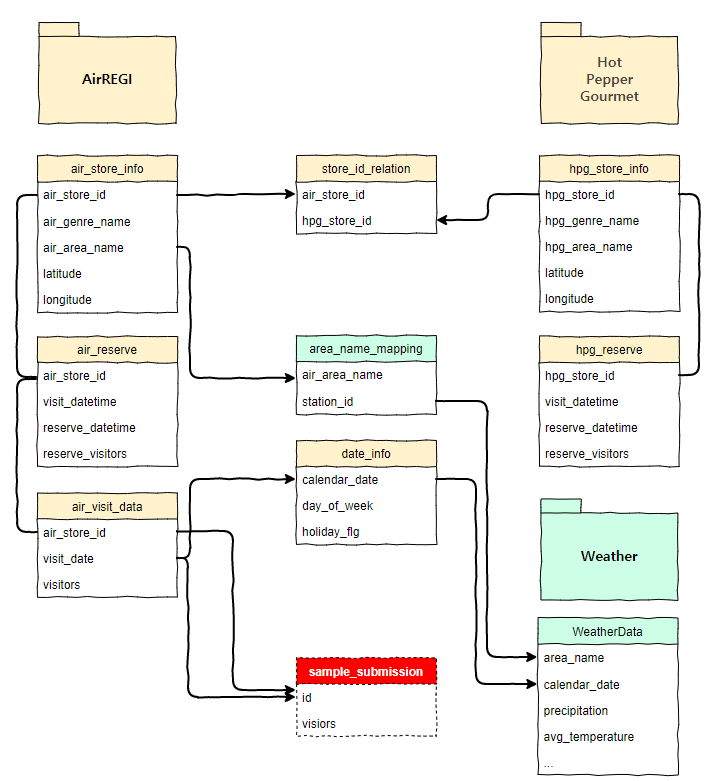

- [목표]
  - 주어진 데이터를 조합하여 최대의 정보를 포함한 `train`과 `test` 테이블을 만들어내자!
  
  
- [주어진 것]
  - 기존의 데이터: air사이트와 hpg사이트로 부터 얻은 두 부류의 데이터가 주어진다.
      - air 데이터
        - `ar`: air_reserve.csv : 인터넷으로 예약한 사람들, 시간별!
        - `as`: air_store_info.csv
        - `tra`: air_visit_data.csv : 실제로 가게에 방문한 사람들, 일자별 visitors
      - hpg 데이터
        - `hr`: hpg_reserve.csv
        - `hs`: hpg_store_info.csv
      - 연결 데이터
        - `id`: store_id_relation.csv
      - 기타 데이터
        - `hol`: date_info.csv

  - 추가 데이터 : 이름과 지역을 매핑한 데이터와 날씨 정보(일본 정부 사이트?)가 주어진다.
     - `anm`: area_name_mapping.csv
     - `wd`: weatherData.csv

In [2]:
import glob, re
import numpy as np
import pandas as pd

from sklearn import ensemble, neighbors, metrics, preprocessing
from datetime import datetime

from xgboost import XGBRegressor
import lightgbm as lgb

In [3]:
# !ls ../input/recruit-restaurant-visitor-forecasting-data

In [4]:
data = {
    'tra': pd.read_csv('../input/recruit-restaurant-visitor-forecasting-data/air_visit_data.csv'),
    'as': pd.read_csv('../input/recruit-restaurant-visitor-forecasting-data/air_store_info.csv'),
    'hs': pd.read_csv('../input/recruit-restaurant-visitor-forecasting-data/hpg_store_info.csv'),
    'ar': pd.read_csv('../input/recruit-restaurant-visitor-forecasting-data/air_reserve.csv'),
    'hr': pd.read_csv('../input/recruit-restaurant-visitor-forecasting-data/hpg_reserve.csv'),
    'id': pd.read_csv('../input/recruit-restaurant-visitor-forecasting-data/store_id_relation.csv'),
    'tes': pd.read_csv('../input/recruit-restaurant-visitor-forecasting-data/sample_submission.csv'),
    'hol': pd.read_csv('../input/recruit-restaurant-visitor-forecasting-data/date_info.csv').rename(columns={'calendar_date':'visit_date'}),
    'wd': pd.read_csv('../input/recruit-restaurant-visitor-forecasting-data/WeatherData.csv'),
    'anm': pd.read_csv('../input/recruit-restaurant-visitor-forecasting-data/area_name_mapping.csv')
}

# EDA

## 0. 전체 데이터 살펴보기
- `wd` 데이터를 제외하고는 missing 데이터가 없음을 알 수 있다
- 테이블 별 데이터 보유량을 볼 수 있다. 25만의 `tra` 데이터로 3만의 `tes`를 예측하게 될 것이라는 걸 알 수 있다
  - 유독 눈에 띄게 `hr`의 데이터가 많다. 하지만 `tra`를 기준으로 데이터를 left merge할 것이다!

In [5]:
from collections import OrderedDict
countdict = OrderedDict()
for key in data.keys(): 
    print(f'---------------------------------------------------------{key}---------------------------------------------------------')
    print(data[key].info())
    print(data[key].isnull().sum())
    countdict[key] = len(data[key])

---------------------------------------------------------tra---------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252108 entries, 0 to 252107
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   air_store_id  252108 non-null  object
 1   visit_date    252108 non-null  object
 2   visitors      252108 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 5.8+ MB
None
air_store_id    0
visit_date      0
visitors        0
dtype: int64
---------------------------------------------------------as---------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   air_store_id    829 non-null    object 
 1   air_genre_name  829 non-null    object 
 2   air_area_name   829 non-null 

In [6]:
from pprint import pprint
pprint(countdict)

OrderedDict([('tra', 252108),
             ('as', 829),
             ('hs', 4690),
             ('ar', 92378),
             ('hr', 2000320),
             ('id', 150),
             ('tes', 32019),
             ('hol', 517),
             ('wd', 33088),
             ('anm', 103)])


In [7]:
for key in data.keys(): 
    print(f'---------------------------------------------------------{key}---------------------------------------------------------')
    print(data[key].head(1))

---------------------------------------------------------tra---------------------------------------------------------
           air_store_id  visit_date  visitors
0  air_ba937bf13d40fb24  2016-01-13        25
---------------------------------------------------------as---------------------------------------------------------
           air_store_id  air_genre_name                 air_area_name  \
0  air_0f0cdeee6c9bf3d7  Italian/French  Hyōgo-ken Kōbe-shi Kumoidōri   

    latitude   longitude  
0  34.695124  135.197853  
---------------------------------------------------------hs---------------------------------------------------------
           hpg_store_id  hpg_genre_name                  hpg_area_name  \
0  hpg_6622b62385aec8bf  Japanese style  Tōkyō-to Setagaya-ku Taishidō   

    latitude   longitude  
0  35.643675  139.668221  
---------------------------------------------------------ar---------------------------------------------------------
           air_store_id       visit

# 🤓 데이터 다루기 순서
1. 개별 테이블 다루기
   - `ar`, `hr`: air_reserve, hr_reserve
   - `tra`: air_visit_data
   - `hol`: date_info
   - `tes`: sample_submission
   
   
2. Stores 테이블 생성하기
   - `tes`: sample_submission에 필요한 `Stores` 테이블 생성
   - `Stores`에 store_data와 visit_date를 넣어줌
   - `Stores`의 열 genre와 area를 라벨 인코딩 해줌


3. Test Train 테이블 생성하기
   - `tes`: sample_submission와 `hol`: date_info에서 `test`를 생성한다
   - `tra`: air_visit_data와 `hol`: date_info에서 `train`을 생성한다
   - `test`와 `train`에 `stores`와 `ar`, `hr`을 merge한 후 다듬는다

## 개별 테이블 다루기

## 1. hr(hpg_reserve)
  - air_store_id 기준으로 데이터를 분석하기 위해 `id`: store_id_relation을 활용해 hpg_reserve에 air_store_id를 추가한다

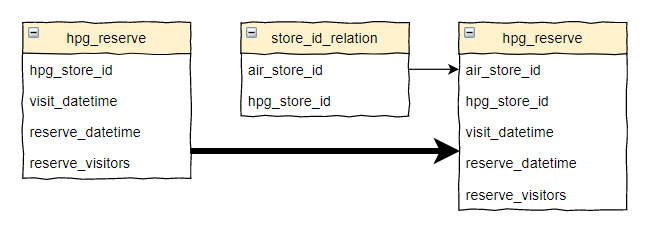

In [8]:
data['hr'] = pd.merge(data['hr'], data['id'], how='inner', on=['hpg_store_id'])

## 2. ar, hr: air/hpq_reserve 테이블
- info( ... ) method로 살펴본 결과 날짜형인 visit_datetime과 reverse_datetime이 object로 되어 있음
- datetime 라이브러리를 이용해 전처리 해주기로 함
  1. datetime형 자료를 변환 후 date(YYYY-MM-DD)만 추리기
  2. 새로운 feature인 reserve_datetime_diff 생성
  3. groupby로 air_store_id, visit_date, rs_sum, rv_sum, rs_mean, rv_mean 꼴로 테이블을 형성한다. [회고] groupby의 사용법을 확실하게 이해할 수 있었다
  
  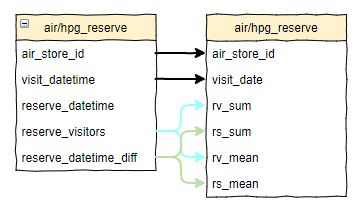
- 참고자료: [[파이썬 datetime] 일자와 시간(dt) 처리법](https://m.blog.naver.com/PostView.nhn?blogId=wideeyed&logNo=221603462366&proxyReferer=https:%2F%2Fwww.google.com%2F)

In [9]:
#TEST
# data['hr'].groupby(['air_store_id','visit_datetime'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].sum()
# .rename(columns={'visit_datetime':'visit_date', 'reserve_datetime_diff': 'rs1', 'reserve_visitors':'rv1'})    

In [10]:
for df in ['ar','hr']:
    #YYYY-MM-DD
    data[df]['visit_datetime'] = pd.to_datetime(data[df]['visit_datetime'])
    data[df]['visit_datetime'] = data[df]['visit_datetime'].dt.date
    
    data[df]['reserve_datetime'] = pd.to_datetime(data[df]['reserve_datetime'])
    data[df]['reserve_datetime'] = data[df]['reserve_datetime'].dt.date
    
    #Feature Engineering: 방문하기까지 며칠이 걸렸을까
    data[df]['reserve_datetime_diff'] = data[df].apply(lambda r: (r['visit_datetime'] - r['reserve_datetime']).days, axis=1)

    #air/hpg_reserve를 다시 만들어준다
    tmp1 = data[df].groupby(['air_store_id','visit_datetime'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].sum().rename(columns={'visit_datetime':'visit_date', 'reserve_datetime_diff': 'rs_sum', 'reserve_visitors': 'rv_sum'})
    tmp2 = data[df].groupby(['air_store_id','visit_datetime'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].mean().rename(columns={'visit_datetime':'visit_date', 'reserve_datetime_diff': 'rs_mean', 'reserve_visitors': 'rv_mean'})
    data[df] = pd.merge(tmp1, tmp2, how='inner', on=['air_store_id','visit_date'])

In [11]:
for df in ['ar','hr']:
    print(data[df].head())

           air_store_id  visit_date  rs_sum  rv_sum  rs_mean  rv_mean
0  air_00a91d42b08b08d9  2016-10-31       0       2      0.0      2.0
1  air_00a91d42b08b08d9  2016-12-05       4       9      4.0      9.0
2  air_00a91d42b08b08d9  2016-12-14       6      18      6.0     18.0
3  air_00a91d42b08b08d9  2016-12-17       6       2      6.0      2.0
4  air_00a91d42b08b08d9  2016-12-20       2       4      2.0      4.0
           air_store_id  visit_date  rs_sum  rv_sum  rs_mean  rv_mean
0  air_00a91d42b08b08d9  2016-01-14       3       2      3.0      2.0
1  air_00a91d42b08b08d9  2016-01-15       6       4      6.0      4.0
2  air_00a91d42b08b08d9  2016-01-16       3       2      3.0      2.0
3  air_00a91d42b08b08d9  2016-01-22       3       2      3.0      2.0
4  air_00a91d42b08b08d9  2016-01-29       6       5      6.0      5.0


# 3. tra: air_visit_data 테이블
- [구성] air_store_id / visit_date / visitors
- visit_date feature를 datetime자료형으로 변환하고 dow, year, month, visit_date로 나눠준다

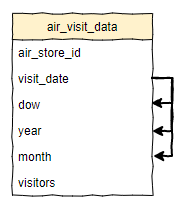

In [12]:
data['tra']['visit_date'] = pd.to_datetime(data['tra']['visit_date'])

In [13]:
#TEST ZONE
# data['tra']['visit_date'].dt.dayofweek
# data['tra']['visit_date'] # 2016-1-13 : 수요일 : 2 => 월요일: 0 
# data['hol']['day_of_week'] # 0번 인덱스: 금요일 => 금요일: 0

In [14]:
data['tra']['dow'] = data['tra']['visit_date'].dt.dayofweek
data['tra']['year'] = data['tra']['visit_date'].dt.year
data['tra']['month'] = data['tra']['visit_date'].dt.month
data['tra']['visit_date'] = data['tra']['visit_date'].dt.date

In [15]:
print(data['tra'].head())

           air_store_id  visit_date  visitors  dow  year  month
0  air_ba937bf13d40fb24  2016-01-13        25    2  2016      1
1  air_ba937bf13d40fb24  2016-01-14        32    3  2016      1
2  air_ba937bf13d40fb24  2016-01-15        29    4  2016      1
3  air_ba937bf13d40fb24  2016-01-16        22    5  2016      1
4  air_ba937bf13d40fb24  2016-01-18         6    0  2016      1


# 4. hol: date_info 테이블
- [구성] visit_date / day_of_week / holiday_flg

In [16]:
lbl = preprocessing.LabelEncoder()

data['hol']['visit_date'] = pd.to_datetime(data['hol']['visit_date'])
data['hol']['visit_date'] = data['hol']['visit_date'].dt.date

data['hol']['day_of_week'] = lbl.fit_transform(data['hol']['day_of_week'])

- `hol`에서 LabelEncoder결과값 
  - array(['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
       'Wednesday'], dtype=object)
  - 'tra'에서 dow와 값이 다르다. 두 값을 맞춰주어야 할 것인가 ?

In [17]:
lbl.classes_

array(['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
       'Wednesday'], dtype=object)

In [18]:
print(data['hol'].head())

   visit_date  day_of_week  holiday_flg
0  2016-01-01            0            1
1  2016-01-02            2            1
2  2016-01-03            3            1
3  2016-01-04            1            0
4  2016-01-05            5            0


# 5. tes: sample_submission 테이블
- [구성] id / visitors
- `tes` :sample_submission의 id에는 **air_store_id**와 **visit_date**의 정보가 함께 있으므로 분리해두자
- 분리한 **visit_date**를 datetime자료형으로 변환하고 **dow**, **year**, **month**, **visit_date**로 나눠준다
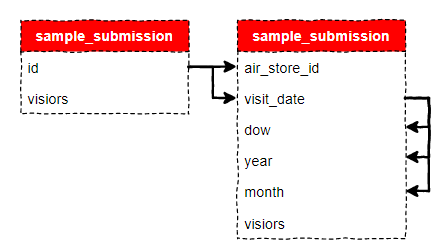

In [19]:
data['tes']['air_store_id'] = data['tes']['id'].map(lambda x: '_'.join(x.split('_')[:2]))
data['tes']['visit_date'] = data['tes']['id'].map(lambda x: str(x).split('_')[2])

data['tes']['visit_date'] = pd.to_datetime(data['tes']['visit_date'])
data['tes']['dow'] = data['tes']['visit_date'].dt.dayofweek
data['tes']['year'] = data['tes']['visit_date'].dt.year
data['tes']['month'] = data['tes']['visit_date'].dt.month
data['tes']['visit_date'] = data['tes']['visit_date'].dt.date

In [20]:
print(data['tes'].head())

                                id  visitors          air_store_id  \
0  air_00a91d42b08b08d9_2017-04-23         0  air_00a91d42b08b08d9   
1  air_00a91d42b08b08d9_2017-04-24         0  air_00a91d42b08b08d9   
2  air_00a91d42b08b08d9_2017-04-25         0  air_00a91d42b08b08d9   
3  air_00a91d42b08b08d9_2017-04-26         0  air_00a91d42b08b08d9   
4  air_00a91d42b08b08d9_2017-04-27         0  air_00a91d42b08b08d9   

   visit_date  dow  year  month  
0  2017-04-23    6  2017      4  
1  2017-04-24    0  2017      4  
2  2017-04-25    1  2017      4  
3  2017-04-26    2  2017      4  
4  2017-04-27    3  2017      4  


## 새로운 테이블 생성하기

## 1. tes: sample_submission 테이블 → stores 테이블
- 전체 데이터셋에서 주어진 상점의 수가 상당히 많으므로, 예측해야 하는 상점의 정보만 톱아보자
- `tes`: sample_submission에서 air_store_id의 unique값에 요일을 합친 `stores` 테이블을 만들어주자
    - **요일별 방문객 수가 큰 영향을 줄 것이라는 예측**에 따른 가게의 요일별 방문객 수를 담기위한 그릇임
    - 실제로 변수 중요도 그래프에서 가장 큰 영향을 주는 변수가 요일인 것을 알 수 있음
  


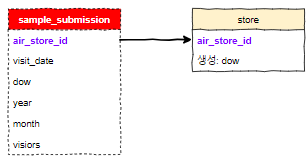

In [21]:
#Test
# unique_stores = data['tes']['air_store_id'].unique()
# print(unique_stores)
# [pd.DataFrame({'air_store_id': unique_stores, 'dow': [i]*len(unique_stores)}) for i in range(7)]
# pd.concat([pd.DataFrame({'air_store_id': unique_stores, 'dow': [i]*len(unique_stores)}) for i in range(7)], axis=0, ignore_index=True).reset_index(drop=True)

In [22]:
unique_stores = data['tes']['air_store_id'].unique()
stores = pd.concat([pd.DataFrame({'air_store_id': unique_stores, 'dow': [i]*len(unique_stores)}) for i in range(7)], axis=0, ignore_index=True)

## 1-1. Stores 테이블 += tra(air_visit_data) + as(air_store_info)

- `stores`테이블에 `tra`: air_visit_data에서 요일별 visitors의 min, mean, median, max 값을 구한 후 merge한다
- `stores`테이블에 `as`:air_store_info를 merge한다, `tes`에 있는 값들에 대해서만 자료가 생성!
> [Tips] 
`store`에 대한 부연설명을 하고 싶을 경우 merge로 left join해 주면 된다!

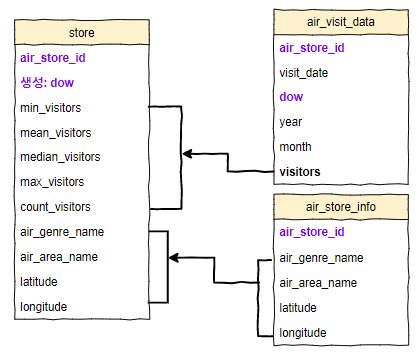

In [23]:
#Test
# data['tra'].groupby(['air_store_id', 'dow'], as_index = False)['visitors'].count()

In [24]:
#air_visit_data에서 요일 데이터를 가져와 store를 부연설명하자
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].min().rename(columns={'visitors':'min_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow']) 
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].mean().rename(columns={'visitors':'mean_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].median().rename(columns={'visitors':'median_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].max().rename(columns={'visitors':'max_visitors'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow'])
tmp = data['tra'].groupby(['air_store_id','dow'], as_index=False)['visitors'].count().rename(columns={'visitors':'count_observations'})
stores = pd.merge(stores, tmp, how='left', on=['air_store_id','dow']) 

#stores에 포함된 데이터들에 대한 store_info를 추가해준다
stores = pd.merge(stores, data['as'], how='left', on=['air_store_id']) 

## 1-2. Stores 테이블 다듬기

1. `stores`의 air_genre_name, air_area_name에 대해 해당 문자열을 split한 후 새로운 컬럼에 담아 Label Encoding을 해 준다
  - 이때 10개의 컬럼으로 나누고 0을 패딩으로 사용한다
  - LabelEncoder는 Label Encoding을 해주는 기능을 가진 클래스로, fit 할 때마다 초기화되고 Label값이 업데이트 된다
    - 참고자료: [LabelEncoder](https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=wideeyed&logNo=221592651246)
    - `apply` vs`map`: `apply`는 dataframe에서 row를 뽑아오고, `map`은 Series에서 element를 뽑아온다
      - 단, 단번에 처리한다!
    - 'Italian/French' → 'Italian French' → 'Italian', 'French' → 0, 0
   
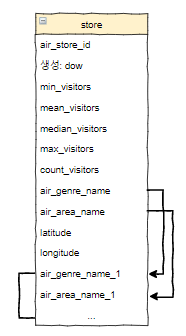

In [25]:
# NEW FEATURES FROM Georgii Vyshnia
stores['air_genre_name'] = stores['air_genre_name'].map(lambda x: str(str(x).replace('/',' ')))
stores['air_area_name'] = stores['air_area_name'].map(lambda x: str(str(x).replace('-',' ')))
for i in range(10):
    stores['air_genre_name'+str(i)] = lbl.fit_transform(stores['air_genre_name'].map(lambda x: str(str(x).split(' ')[i]) if len(str(x).split(' '))>i else ''))
    stores['air_area_name'+str(i)] = lbl.fit_transform(stores['air_area_name'].map(lambda x: str(str(x).split(' ')[i]) if len(str(x).split(' '))>i else ''))
stores['air_genre_name'] = lbl.fit_transform(stores['air_genre_name'])
stores['air_area_name'] = lbl.fit_transform(stores['air_area_name'])

# Train Test 테이블 생성하기

## 1. train, test 테이블 생성 from tra, tes, hol 테이블
- `tra`: air_visit_data와 `hol`: date_info테이블 병합하여 `train` 생성
  - [Trouble] dow와 days_of_week의 차이 ? dow는 월요일을 0으로 days_of_week는 금요일을 0으로 인코딩 됨
- `tes`: sample_submission와 `hol`: date_info테이블 병합하여 `test` 생성

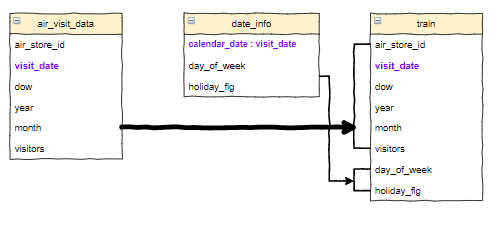
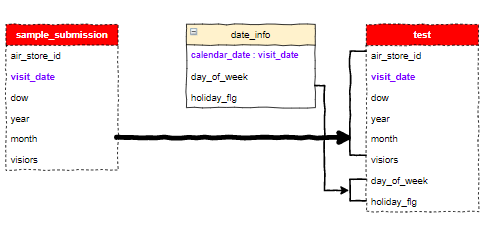

In [26]:
train = pd.merge(data['tra'], data['hol'], how='left', on=['visit_date']) 
test = pd.merge(data['tes'], data['hol'], how='left', on=['visit_date']) 

## 2. train과 test 테이블에 정리된 테이블 추가

- `stores` 테이블 추가
  - 이때, `stores`는 `tes`로 부터 만들어진 자료로, `train`에는 결측치가 있을 수 있고, `test`에는 결측치가 없음

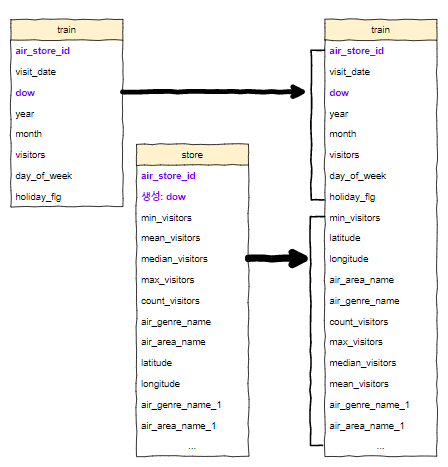
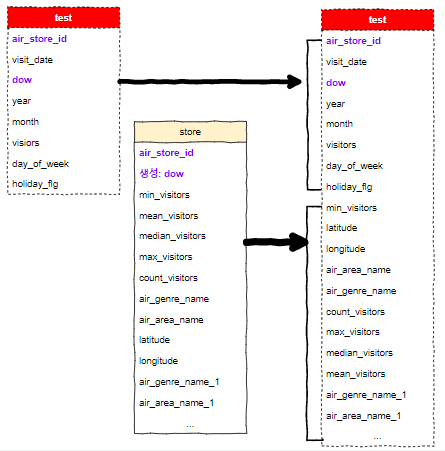

In [27]:
train = pd.merge(train, stores, how='left', on=['air_store_id','dow']) 
test = pd.merge(test, stores, how='left', on=['air_store_id','dow'])

In [28]:
#TEST
# test.isnull().sum()

- ar: air_reserve와 hr: hpg_reserve 테이블 추가
  - ~~[Trouble] 'hr'의 열만 포함되는 문제: 왜?? 돌면서 적용되는걸 테스트용으로 만들어서 적용x~~

In [29]:
for df in ['ar','hr']:
    train = pd.merge(train, data[df], how='left', on=['air_store_id','visit_date'])
#     print(train.columns)
    test = pd.merge(test, data[df], how='left', on=['air_store_id','visit_date'])
#     print(test.columns)

## 3. train, test 테이블 다듬기

- id: air_store_id 와 visit_date를 다시 합쳐서 원래의 id를 만들기

In [30]:
train['id'] = train.apply(lambda r: '_'.join([str(r['air_store_id']), str(r['visit_date'])]), axis=1)

### Feature Engineering

- total_reserv_sum : 총 예약인원
- total_reserv_mean : 평균 예약인원
- total_reserv_dt_diff_mean : 예약과 방문까지의 평균기간

In [31]:
#(예약했다면) 총 예약인원과 평균 예약인원이 얼마인지
train['total_reserv_sum'] = train['rv_sum_x'] + train['rv_sum_y']
train['total_reserv_mean'] = (train['rv_mean_x'] + train['rv_mean_y']) / 2
#(예약했다면) 예약과 방문까지의 평균기간이 얼마인지
train['total_reserv_dt_diff_mean'] = (train['rs_mean_x'] + train['rs_mean_y']) / 2

#(예약했다면) 총 예약인원과 평균 예약인원이 얼마인지
test['total_reserv_sum'] = test['rv_sum_x'] + test['rv_sum_y']
test['total_reserv_mean'] = (test['rv_mean_x'] + test['rv_mean_y']) / 2
#(예약했다면) 예약과 방문까지의 평균기간이 얼마인지
test['total_reserv_dt_diff_mean'] = (test['rs_mean_x'] + test['rs_mean_y']) / 2

- 방문일자를 datetime자료형에서 수치형으로 변환
- 위도 경도의 offset
- 위도와 경도의 합

In [32]:
# 날짜를 수치형 데이터로 변환
train['date_int'] = train['visit_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
test['date_int'] = test['visit_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)

#위도 경도의 offset
train['var_max_lat'] = train['latitude'].max() - train['latitude']
train['var_max_long'] = train['longitude'].max() - train['longitude']
test['var_max_lat'] = test['latitude'].max() - test['latitude']
test['var_max_long'] = test['longitude'].max() - test['longitude']

# 위도 경도의 합
train['lon_plus_lat'] = train['longitude'] + train['latitude'] 
test['lon_plus_lat'] = test['longitude'] + test['latitude']

- store_id를 Label로 인코딩

In [33]:
lbl = preprocessing.LabelEncoder()
train['air_store_id2'] = lbl.fit_transform(train['air_store_id'])
test['air_store_id2'] = lbl.transform(test['air_store_id'])

In [65]:
print(train.columns)
train

Index(['air_store_id', 'visit_date', 'visitors', 'dow', 'year', 'month',
       'day_of_week', 'holiday_flg', 'min_visitors', 'mean_visitors',
       'median_visitors', 'max_visitors', 'count_observations',
       'air_genre_name', 'air_area_name', 'latitude', 'longitude',
       'air_genre_name0', 'air_area_name0', 'air_genre_name1',
       'air_area_name1', 'air_genre_name2', 'air_area_name2',
       'air_genre_name3', 'air_area_name3', 'air_genre_name4',
       'air_area_name4', 'air_genre_name5', 'air_area_name5',
       'air_genre_name6', 'air_area_name6', 'air_genre_name7',
       'air_area_name7', 'air_genre_name8', 'air_area_name8',
       'air_genre_name9', 'air_area_name9', 'rs_sum_x', 'rv_sum_x',
       'rs_mean_x', 'rv_mean_x', 'rs_sum_y', 'rv_sum_y', 'rs_mean_y',
       'rv_mean_y', 'id', 'total_reserv_sum', 'total_reserv_mean',
       'total_reserv_dt_diff_mean', 'date_int', 'var_max_lat', 'var_max_long',
       'lon_plus_lat', 'air_store_id2'],
      dtype='object')


,air_store_id,visit_date,visitors,dow,year,month,day_of_week,holiday_flg,min_visitors,mean_visitors,...,rv_mean_y,id,total_reserv_sum,total_reserv_mean,total_reserv_dt_diff_mean,date_int,var_max_lat,var_max_long,lon_plus_lat,air_store_id2
0,air_ba937bf13d40fb24,2016-01-13,25,2,2016,1,6,0,7.0,23.843750,...,NaN,air_ba937bf13d40fb24_2016-01-13,NaN,NaN,NaN,20160113,8.362564,4.521799,175.409667,603
1,air_ba937bf13d40fb24,2016-01-14,32,3,2016,1,4,0,2.0,20.292308,...,NaN,air_ba937bf13d40fb24_2016-01-14,NaN,NaN,NaN,20160114,8.362564,4.521799,175.409667,603
2,air_ba937bf13d40fb24,2016-01-15,29,4,2016,1,0,0,4.0,34.738462,...,NaN,air_ba937bf13d40fb24_2016-01-15,NaN,NaN,NaN,20160115,8.362564,4.521799,175.409667,603
3,air_ba937bf13d40fb24,2016-01-16,22,5,2016,1,2,0,6.0,27.651515,...,NaN,air_ba937bf13d40fb24_2016-01-16,NaN,NaN,NaN,20160116,8.362564,4.521799,175.409667,603
4,air_ba937bf13d40fb24,2016-01-18,6,0,2016,1,1,0,2.0,13.754386,...,NaN,air_ba937bf13d40fb24_2016-01-18,NaN,NaN,NaN,20160118,8.362564,4.521799,175.409667,603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252103,air_24e8414b9b07decb,2017-04-18,6,1,2017,4,5,0,2.0,5.615385,...,NaN,air_24e8414b9b07decb_2017-04-18,NaN,NaN,NaN,20170418,8.367414,4.562362,175.364254,98
252104,air_24e8414b9b07decb,2017-04-19,6,2,2017,4,6,0,2.0,6.575000,...,NaN,air_24e8414b9b07decb_2017-04-19,NaN,NaN,NaN,20170419,8.367414,4.562362,175.364254,98
252105,air_24e8414b9b07decb,2017-04-20,7,3,2017,4,4,0,2.0,5.394737,...,NaN,air_24e8414b9b07decb_2017-04-20,NaN,NaN,NaN,20170420,8.367414,4.562362,175.364254,98
252106,air_24e8414b9b07decb,2017-04-21,8,4,2017,4,0,0,2.0,5.738095,...,NaN,air_24e8414b9b07decb_2017-04-21,NaN,NaN,NaN,20170421,8.367414,4.562362,175.364254,98


In [66]:
print(test.columns)
test

Index(['id', 'visitors', 'air_store_id', 'visit_date', 'dow', 'year', 'month',
       'day_of_week', 'holiday_flg', 'min_visitors', 'mean_visitors',
       'median_visitors', 'max_visitors', 'count_observations',
       'air_genre_name', 'air_area_name', 'latitude', 'longitude',
       'air_genre_name0', 'air_area_name0', 'air_genre_name1',
       'air_area_name1', 'air_genre_name2', 'air_area_name2',
       'air_genre_name3', 'air_area_name3', 'air_genre_name4',
       'air_area_name4', 'air_genre_name5', 'air_area_name5',
       'air_genre_name6', 'air_area_name6', 'air_genre_name7',
       'air_area_name7', 'air_genre_name8', 'air_area_name8',
       'air_genre_name9', 'air_area_name9', 'rs_sum_x', 'rv_sum_x',
       'rs_mean_x', 'rv_mean_x', 'rs_sum_y', 'rv_sum_y', 'rs_mean_y',
       'rv_mean_y', 'total_reserv_sum', 'total_reserv_mean',
       'total_reserv_dt_diff_mean', 'date_int', 'var_max_lat', 'var_max_long',
       'lon_plus_lat', 'air_store_id2'],
      dtype='object')


,id,visitors,air_store_id,visit_date,dow,year,month,day_of_week,holiday_flg,min_visitors,...,rs_mean_y,rv_mean_y,total_reserv_sum,total_reserv_mean,total_reserv_dt_diff_mean,date_int,var_max_lat,var_max_long,lon_plus_lat,air_store_id2
0,air_00a91d42b08b08d9_2017-04-23,0,air_00a91d42b08b08d9,2017-04-23,6,2017,4,3,0,2.0,...,NaN,NaN,NaN,NaN,NaN,20170423,8.326629,4.519803,175.447598,0
1,air_00a91d42b08b08d9_2017-04-24,0,air_00a91d42b08b08d9,2017-04-24,0,2017,4,1,0,1.0,...,NaN,NaN,NaN,NaN,NaN,20170424,8.326629,4.519803,175.447598,0
2,air_00a91d42b08b08d9_2017-04-25,0,air_00a91d42b08b08d9,2017-04-25,1,2017,4,5,0,1.0,...,NaN,NaN,NaN,NaN,NaN,20170425,8.326629,4.519803,175.447598,0
3,air_00a91d42b08b08d9_2017-04-26,0,air_00a91d42b08b08d9,2017-04-26,2,2017,4,6,0,15.0,...,NaN,NaN,NaN,NaN,NaN,20170426,8.326629,4.519803,175.447598,0
4,air_00a91d42b08b08d9_2017-04-27,0,air_00a91d42b08b08d9,2017-04-27,3,2017,4,4,0,15.0,...,NaN,NaN,NaN,NaN,NaN,20170427,8.326629,4.519803,175.447598,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32014,air_fff68b929994bfbd_2017-05-27,0,air_fff68b929994bfbd,2017-05-27,5,2017,5,2,0,2.0,...,NaN,NaN,NaN,NaN,NaN,20170527,8.312486,4.607110,175.374434,828
32015,air_fff68b929994bfbd_2017-05-28,0,air_fff68b929994bfbd,2017-05-28,6,2017,5,3,0,1.0,...,NaN,NaN,NaN,NaN,NaN,20170528,8.312486,4.607110,175.374434,828
32016,air_fff68b929994bfbd_2017-05-29,0,air_fff68b929994bfbd,2017-05-29,0,2017,5,1,0,1.0,...,NaN,NaN,NaN,NaN,NaN,20170529,8.312486,4.607110,175.374434,828
32017,air_fff68b929994bfbd_2017-05-30,0,air_fff68b929994bfbd,2017-05-30,1,2017,5,5,0,1.0,...,NaN,NaN,NaN,NaN,NaN,20170530,8.312486,4.607110,175.374434,828


# 시각화를 통한 EDA

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
# EDA 용 데이터 따로 불러읽음
# read data from diretories
dir = '../input/recruit-restaurant-visitor-forecasting-data/'
eda = {
    'avd': pd.read_csv(dir+'air_visit_data.csv'),
    'asi': pd.read_csv(dir+'air_store_info.csv'),
    'hsi': pd.read_csv(dir+'hpg_store_info.csv'),
    'ar': pd.read_csv(dir+'air_reserve.csv'),
    'hr': pd.read_csv(dir+'hpg_reserve.csv'),
    'sid': pd.read_csv(dir+'store_id_relation.csv'),
    'sample': pd.read_csv(dir+'sample_submission.csv'),
    'data_info': pd.read_csv(dir+'date_info.csv').rename(columns={'calendar_date':'visit_date'})
    }


In [38]:
# hr 데이터 추가하려면 여기
print(type(eda['ar']['visit_datetime'][0]))
print(eda['ar']['visit_datetime'][0][11:13])
eda['ar']['v_hr'] = eda['ar']['visit_datetime'].str[11:13]
eda['ar']['r_hr'] = eda['ar']['reserve_datetime'].str[11:13]
eda['hr']['v_hr'] = eda['hr']['visit_datetime'].str[11:13]
eda['hr']['r_hr'] = eda['hr']['reserve_datetime'].str[11:13]
# display(data['ar'].head())
# display(data['hr'].head())

<class 'str'>
19


In [39]:
def check_data():
    for key in eda.keys():
        print(key,': ',eda[key].columns)
check_data()

avd :  Index(['air_store_id', 'visit_date', 'visitors'], dtype='object')
asi :  Index(['air_store_id', 'air_genre_name', 'air_area_name', 'latitude',
       'longitude'],
      dtype='object')
hsi :  Index(['hpg_store_id', 'hpg_genre_name', 'hpg_area_name', 'latitude',
       'longitude'],
      dtype='object')
ar :  Index(['air_store_id', 'visit_datetime', 'reserve_datetime',
       'reserve_visitors', 'v_hr', 'r_hr'],
      dtype='object')
hr :  Index(['hpg_store_id', 'visit_datetime', 'reserve_datetime',
       'reserve_visitors', 'v_hr', 'r_hr'],
      dtype='object')
sid :  Index(['air_store_id', 'hpg_store_id'], dtype='object')
sample :  Index(['id', 'visitors'], dtype='object')
data_info :  Index(['visit_date', 'day_of_week', 'holiday_flg'], dtype='object')


In [40]:
# 각 reserve 파일의 store_id 비교
print(len(eda['ar']['air_store_id'].unique()))  # store id 314개
print(len(eda['hr']['hpg_store_id'].unique()))  # store id 13325개 말이 안되는데;;
print(len(eda['asi']['air_store_id'].unique()))  # 왜 ar의 갯수와 다르지
print(len(eda['hsi']['hpg_store_id'].unique()))  # 얘도...

print(len((eda['hsi']['hpg_store_id']).sort_values().unique())) # sort 여부는 상관이 없네...
print(len(eda['hr']['hpg_store_id'].sort_values().unique()))

314
13325
829
4690
4690
13325


## tra: air_visit_data

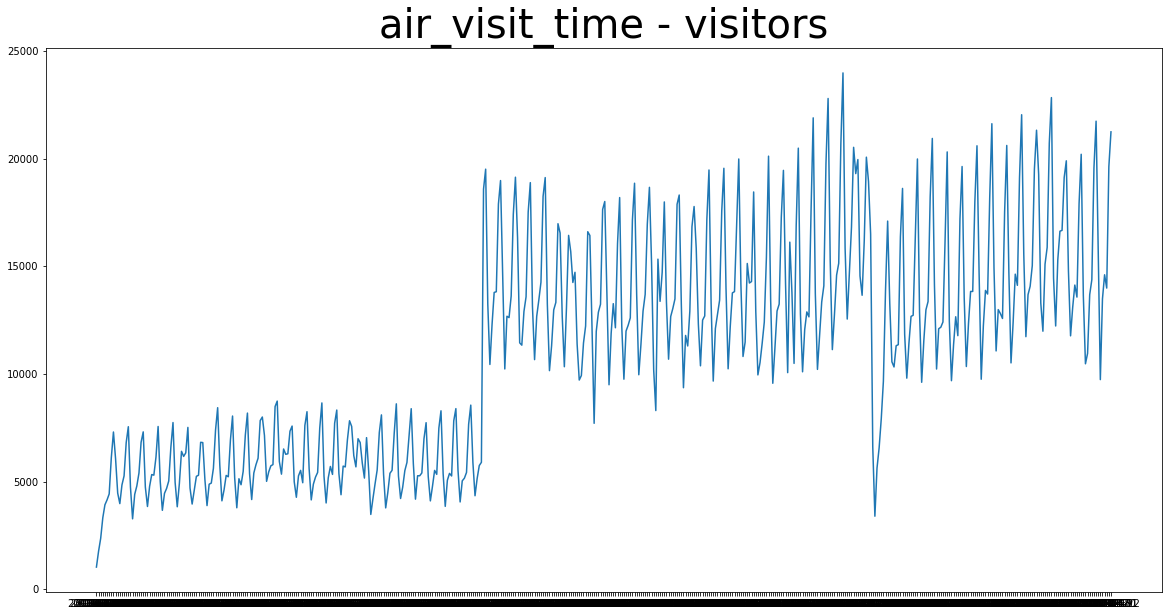

In [41]:
# graph from 'air_visit_data'
a5 = eda['avd'].groupby(['visit_date'], as_index=False)['visitors'].sum()

plt.figure(figsize=(20,10))
# ax5 = plt.subplot(411)
ax5 = plt.title('air_visit_time - visitors',fontsize=40)
plt.plot(a5['visit_date'],a5['visitors'])

In [42]:
eda['avd']['visit_date'] = pd.to_datetime(eda['avd']['visit_date'])
eda['avd']['dow'] = eda['avd']['visit_date'].dt.dayofweek
eda['avd']['year'] = eda['avd']['visit_date'].dt.year
eda['avd']['month'] = eda['avd']['visit_date'].dt.month
eda['avd']['visit_date'] = eda['avd']['visit_date'].dt.date

eda['avd'].head()

,air_store_id,visit_date,visitors,dow,year,month
0,air_ba937bf13d40fb24,2016-01-13,25,2,2016,1
1,air_ba937bf13d40fb24,2016-01-14,32,3,2016,1
2,air_ba937bf13d40fb24,2016-01-15,29,4,2016,1
3,air_ba937bf13d40fb24,2016-01-16,22,5,2016,1
4,air_ba937bf13d40fb24,2016-01-18,6,0,2016,1


In [43]:
_day = ['Mon','Tue','Wed','Thur','Fri','Sat','Sun']

print(eda['avd']['dow'].unique())
dow_ = eda['avd'].groupby(['dow'], as_index=False)['visitors'].sum()
dow_

[2 3 4 5 0 1 6]


,dow,visitors
0,0,544202
1,1,636462
2,2,707880
3,3,718987
4,4,931008
5,5,1033128
6,6,715986


# ar, hr: air_reserve, hpg_reserve

In [44]:
a1 = eda['ar'].groupby(['visit_datetime'], as_index=False)['reserve_visitors'].sum()
a2 = eda['ar'].groupby(['reserve_datetime'], as_index=False)['reserve_visitors'].sum()
a3 = eda['hr'].groupby(['visit_datetime'], as_index=False)['reserve_visitors'].sum()
a4 = eda['hr'].groupby(['reserve_datetime'], as_index=False)['reserve_visitors'].sum()

<AxesSubplot:title={'center':'data shape'}, xlabel='visit_date', ylabel='visitors'>

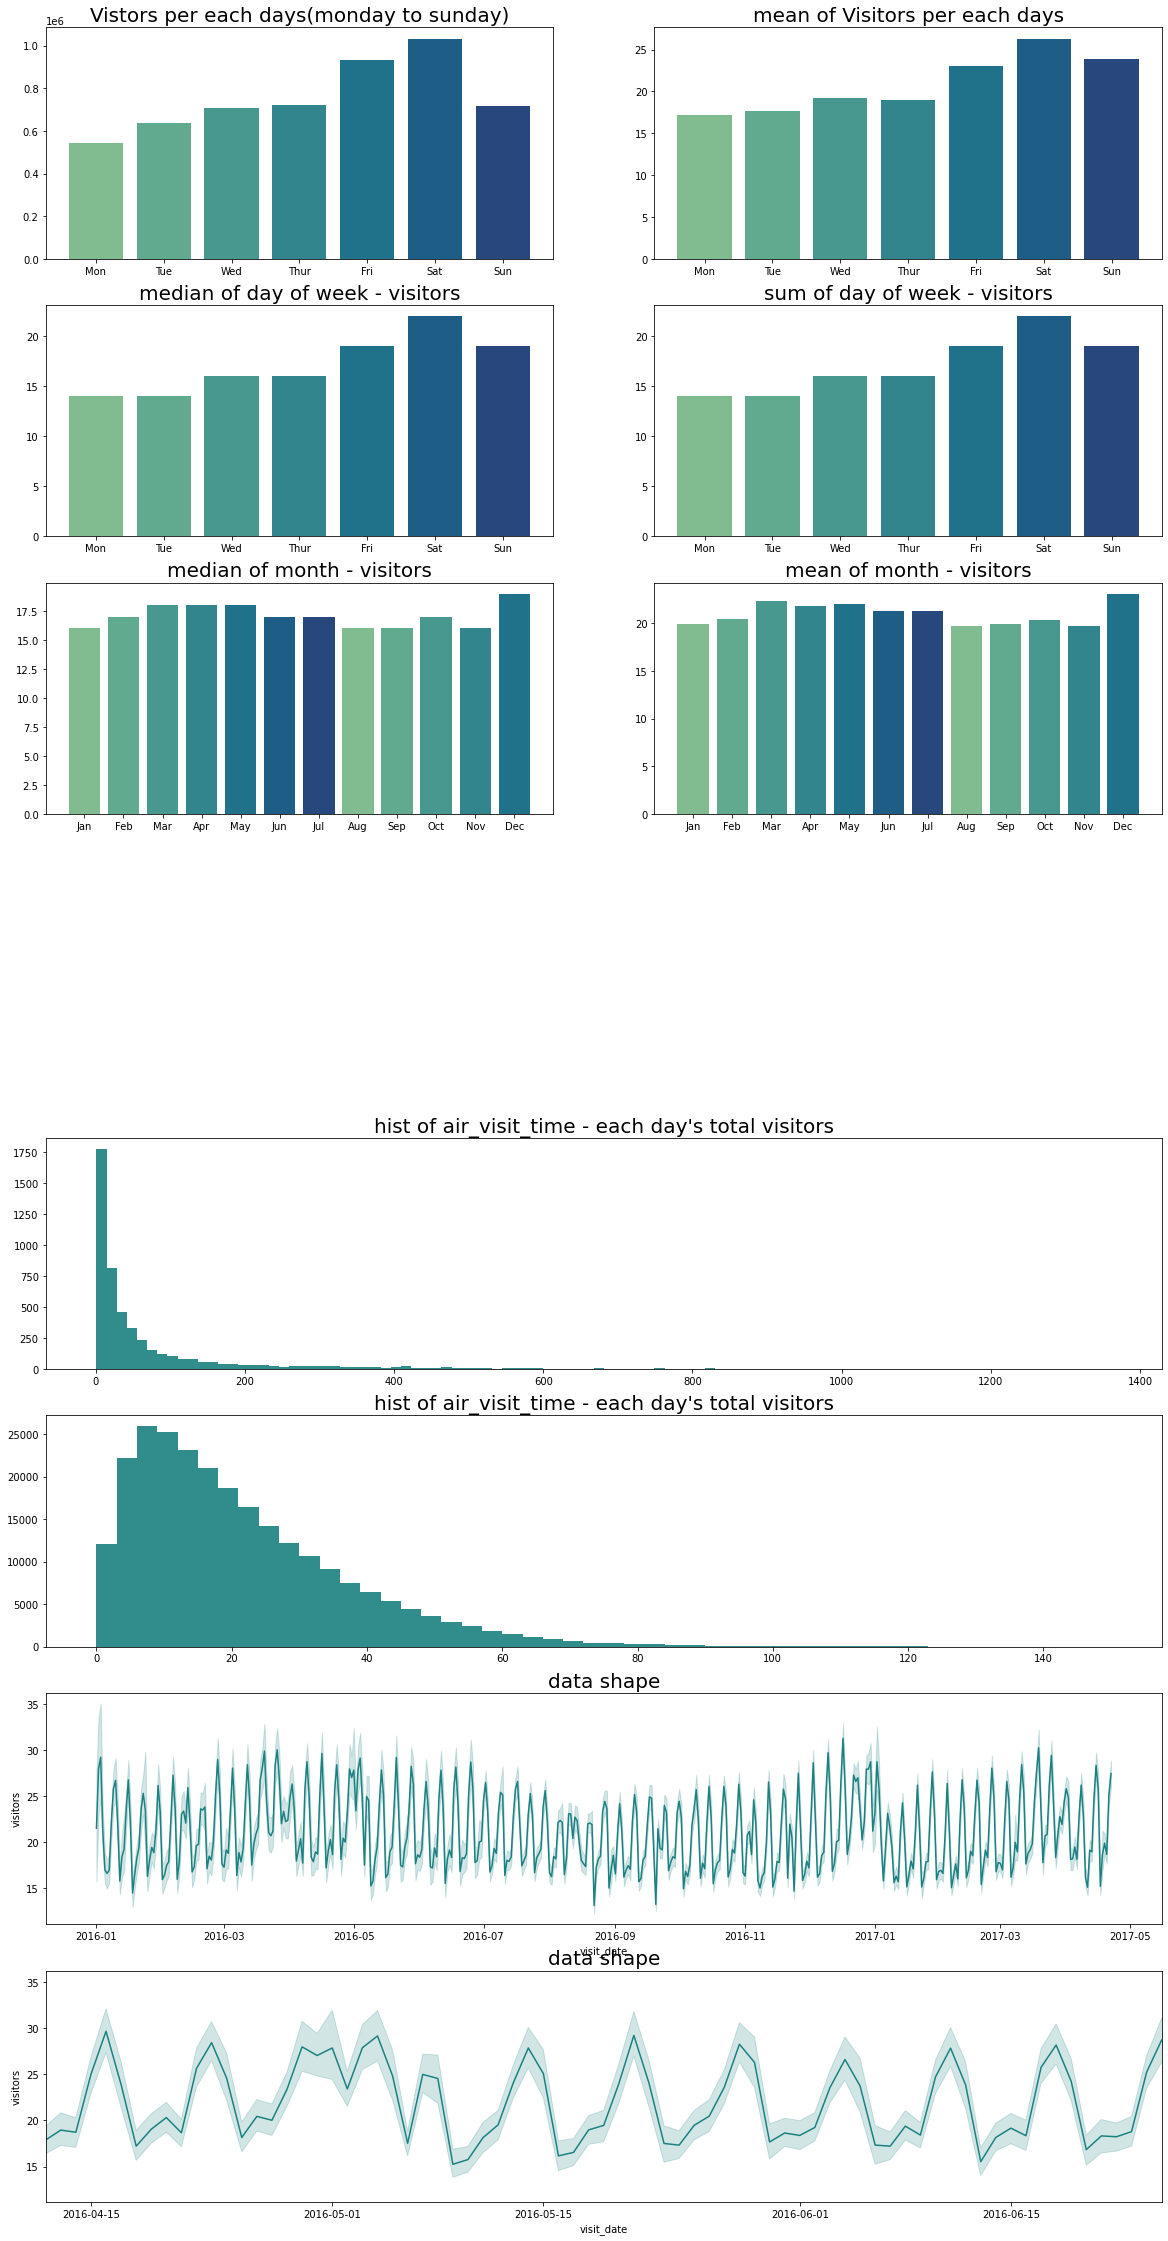

In [45]:
# subplot 으로 데이터를 각각 보여줌
rows = 8
cols = 2
_fontsize = 20
colors = sns.color_palette("crest", len(dow_['visitors']))

day_dict = {0:'Mon',1:'Tue',2:'Wed',3:'Thur',4:'Fri',5:'Sat',6:'Sun'}
_day = ['Mon','Tue','Wed','Thur','Fri','Sat','Sun']
_month = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

plt.figure(figsize=(20,40))

plt.subplot(rows,cols,1)
plt.title('Vistors per each days(monday to sunday)', fontsize=_fontsize)
plt.bar(_day,dow_['visitors'],color=colors)

plt.subplot(rows,cols,2)
dow_mean = eda['avd'].groupby(['dow'], as_index=False)['visitors'].mean()
plt.title('mean of Visitors per each days', fontsize=_fontsize)
plt.bar(_day,dow_mean['visitors'],color=colors)

plt.subplot(rows,cols,3)
dow_med = eda['avd'].groupby(['dow'], as_index=False)['visitors'].median()
plt.title('median of day of week - visitors', fontsize=_fontsize)
plt.bar(_day,dow_med['visitors'],color=colors)

plt.subplot(rows,cols,4)
dow_sum = eda['avd'].groupby(['dow'], as_index=False)['visitors'].sum()
plt.title('sum of day of week - visitors', fontsize=_fontsize)
plt.bar(_day,dow_med['visitors'],color=colors)

plt.subplot(rows,cols,5)
plt.title('median of month - visitors', fontsize=_fontsize)
plt.bar(_month,eda['avd'].groupby(['month'], as_index=False)['visitors'].median()['visitors'],color=colors)

plt.subplot(rows,cols,6)
plt.title('mean of month - visitors', fontsize=_fontsize)
plt.bar(_month,eda['avd'].groupby(['month'], as_index=False)['visitors'].mean()['visitors'],color=colors)

# plt.subplot(rows,cols,7)
# plt.title('sum of month - visitors', fontsize=_fontsize)
# plt.bar(_month,eda['avd'].groupby(['month'], as_index=False)['visitors'].sum()['visitors'])

# plt.subplot(rows,cols,8)
# plt.title('mean of month - visitors', fontsize=40)
# plt.bar(_month,eda['avd'].groupby(['month'], as_index=False)['visitors'].mean()['visitors'])


plt.subplot(rows,cols-1,5)
plt.title('hist of air_visit_time - each day\'s total visitors',fontsize=_fontsize)
plt.hist(a1['reserve_visitors'], bins=100, density=False, alpha=0.9, histtype='stepfilled',color=(0.1,0.5,0.5))

plt.subplot(rows,cols-1,6)
plt.title('hist of air_visit_time - each day\'s total visitors',fontsize=_fontsize)
plt.hist(eda['avd']['visitors'], bins=50, range=[0, 150],density=False, alpha=0.9, histtype='stepfilled',color=(0.1,0.5,0.5))

plt.subplot(rows, cols-1, 7)
plt.title('data shape',fontsize=_fontsize)
sns.lineplot(x='visit_date',y='visitors',data=eda['avd'],color=(0.1,0.5,0.5))

plt.subplot(rows, cols-1, 8)
plt.title('data shape',fontsize=_fontsize)
plt.xlim(eda['avd']['visit_date'].iloc[75],eda['avd']['visit_date'].iloc[135])
sns.lineplot(x='visit_date',y='visitors',data=eda['avd'],color=(0.1,0.5,0.5) )


In [ ]:
ar = eda['ar']
hr = eda['hr']

a1 = ar.groupby(['visit_datetime'], as_index=False)['reserve_visitors'].sum()
# a2 = ar.groupby(['reserve_datetime'], as_index=False)['reserve_visitors'].sum()
# a3 = hr.groupby(['visit_datetime'], as_index=False)['reserve_visitors'].sum()
# a4 = hr.groupby(['reserve_datetime'], as_index=False)['reserve_visitors'].sum()

plt.figure(figsize=(20,10))
# ax1 = plt.subplot(411)
plt.title('air_visit_date - visitors',fontsize=_fontsize)
sns.lineplot(x = 'visit_datetime', y = 'reserve_visitors', data = a1 ,color=(0.1,0.5,0.5))
# ax2 = plt.subplot(412)
# plt.figure(figsize=(20,10))
# ax2 = plt.title('air_reserve_time - visitors',fontsize=_fontsize)
# plt.plot(a2['reserve_datetime'],a2['reserve_visitors'],color=(0.1,0.5,0.5))

# ax3 = plt.subplot(413)
# plt.figure(figsize=(20,10))
# ax3 = plt.title('hpg_visit_time - visitors',fontsize=_fontsize)
# plt.plot(a3['visit_datetime'],a3['reserve_visitors'],color=(0.1,0.5,0.5))

# ax4 = plt.subplot(414)
# plt.figure(figsize=(20,10))
# ax4 = plt.title('hpg_reserve_time - visitors',fontsize=_fontsize)
# plt.plot(a4['reserve_datetime'],a4['reserve_visitors'],color=(0.1,0.5,0.5))

plt.show()

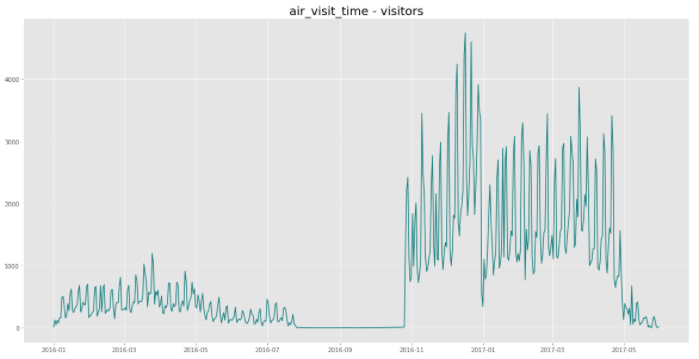

Visit hour 별 vistors 수 확인
- hour 데이터 추가 string slicing [링크](https://stackoverflow.com/questions/25789445/pandas-make-new-column-from-string-slice-of-another-column)

- 사람들이 많이 방문하는 시간대 확인
    - 시간별로 방문하는 사람 수로도 값을 예측함에 영향을 줄 것으로 예상

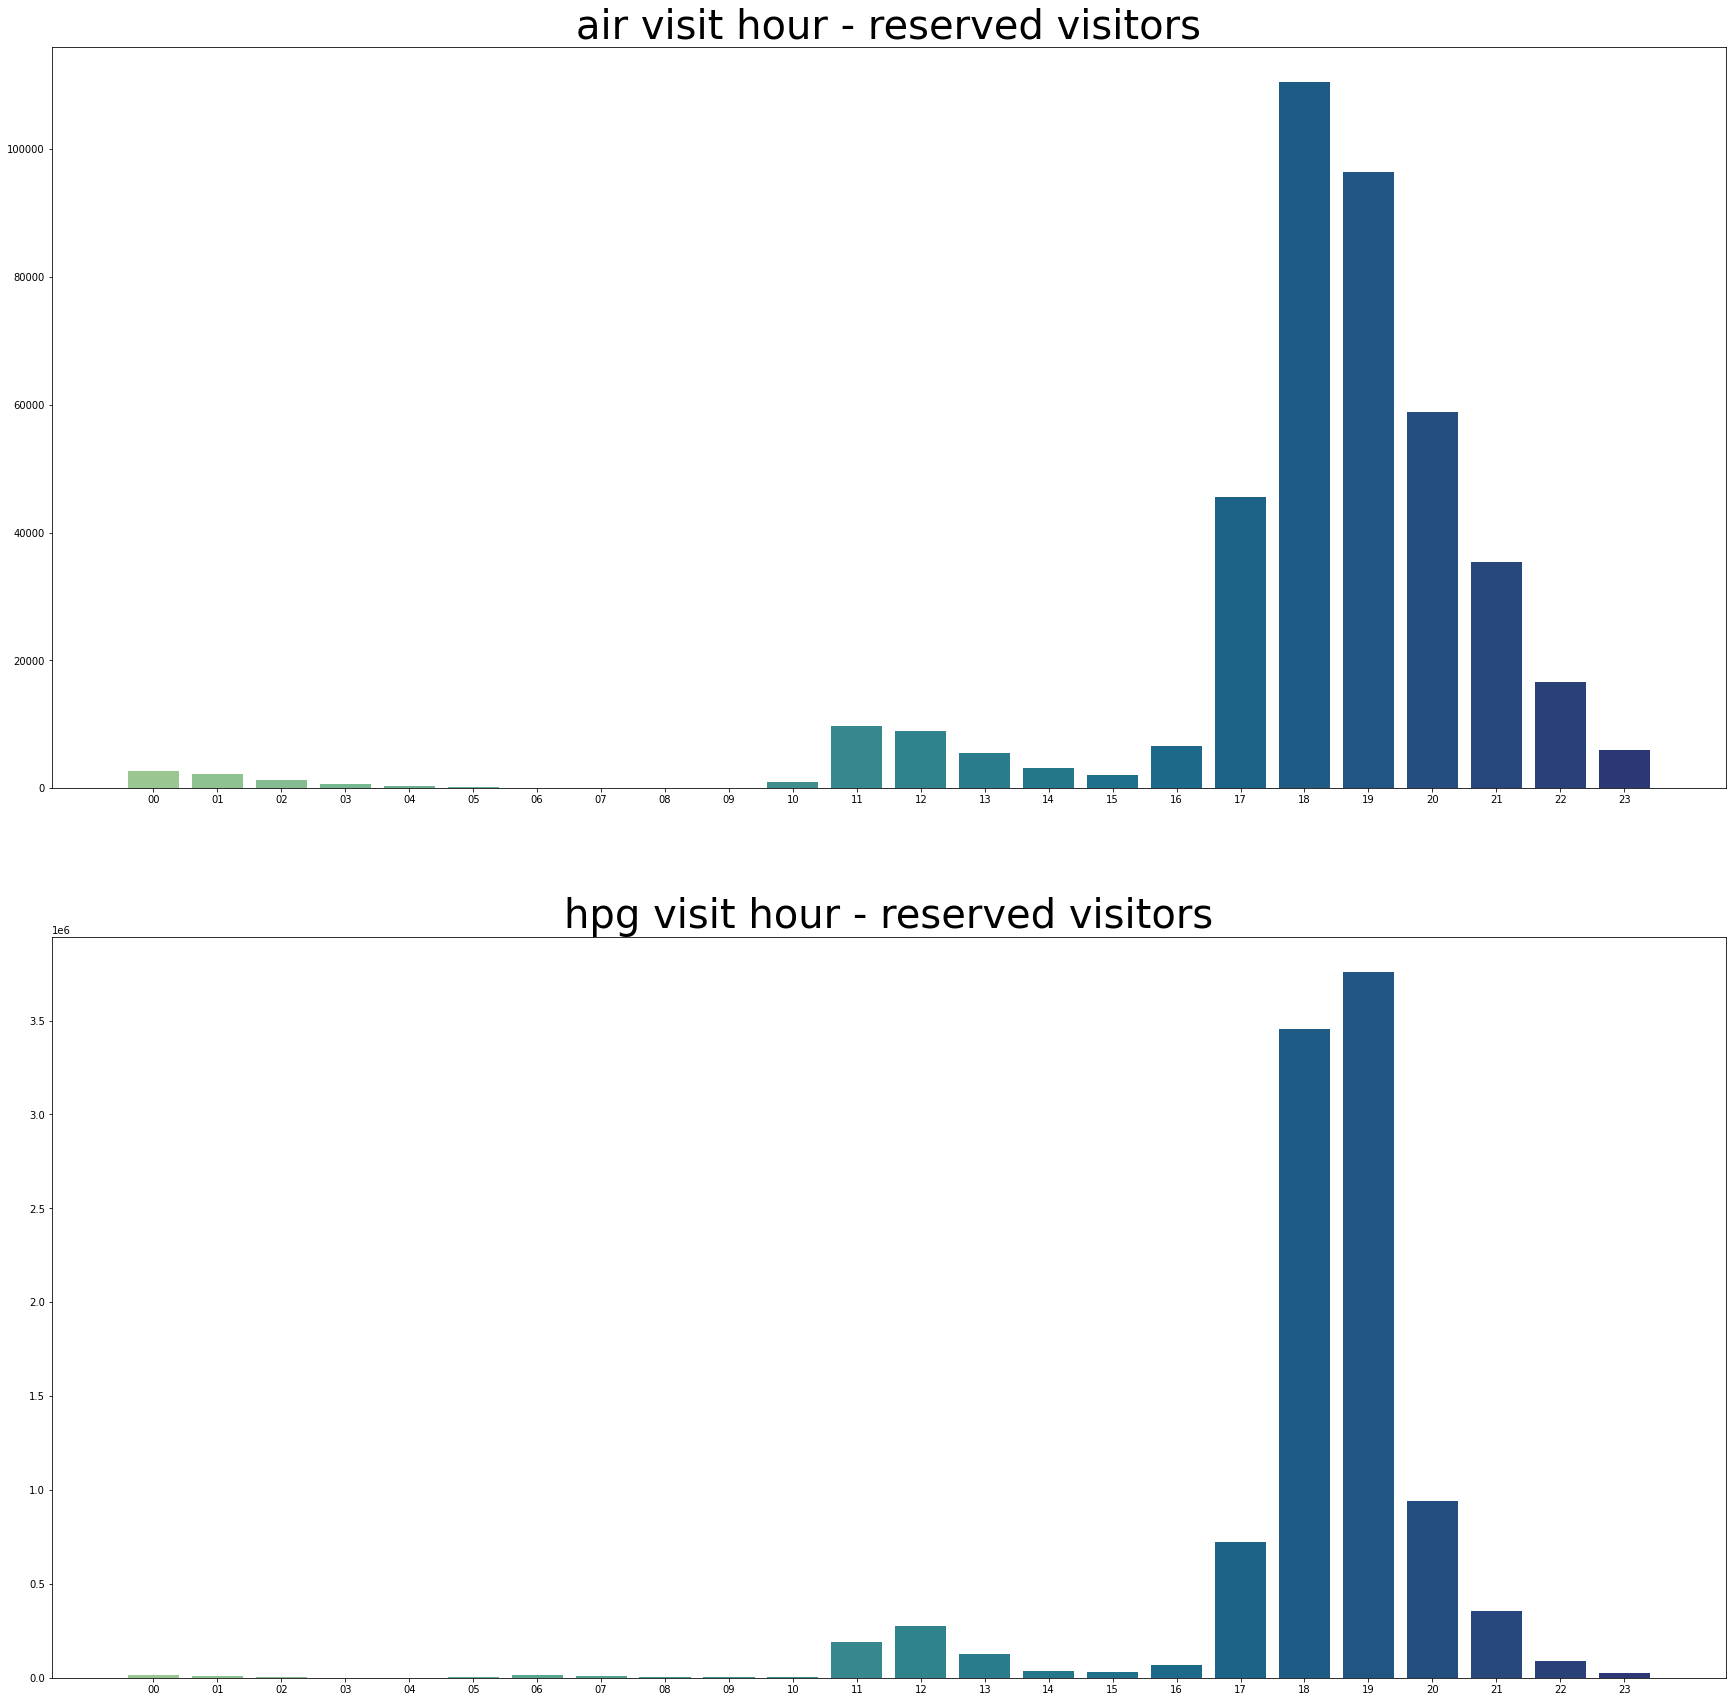

In [52]:
plt.figure(figsize=(30,30))


ax1 = plt.subplot(211)
ax1 = plt.title('air visit hour - reserved visitors',fontsize=40)
visu = eda['ar'].groupby(['v_hr'], as_index=False)['reserve_visitors'].sum()
colors = sns.color_palette("crest", len(visu['reserve_visitors']))
plt.bar(visu['v_hr'],visu['reserve_visitors'],color=colors)

ax2 = plt.subplot(212)
ax2 = plt.title('hpg visit hour - reserved visitors',fontsize=40)
visu = eda['hr'].groupby(['v_hr'], as_index=False)['reserve_visitors'].sum()
plt.bar(visu['v_hr'],visu['reserve_visitors'],color=colors)

plt.show()

- Reserve time, Visit time 비교해본 결과 당일 예약이 꽤 많음

In [177]:
eda['ar'].head(20)

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,v_hr,r_hr
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,19,16
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3,19,19
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6,19,19
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,20,16
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5,20,01
5,air_db80363d35f10926,2016-01-02 01:00:00,2016-01-01 16:00:00,2,01,16
6,air_db80363d35f10926,2016-01-02 01:00:00,2016-01-01 15:00:00,4,01,15
7,air_3bb99a1fe0583897,2016-01-02 16:00:00,2016-01-02 14:00:00,2,16,14
8,air_3bb99a1fe0583897,2016-01-02 16:00:00,2016-01-01 20:00:00,2,16,20
9,air_2b8b29ddfd35018e,2016-01-02 17:00:00,2016-01-02 17:00:00,2,17,17


- 'diff' 라는 column 추가
    - 몇일 전에 방문할 곳에 대한 예약을 진행하는 지

In [55]:
# 'visit_datetime'  or   'visit_date'
for df in ['ar','hr']:
    eda[df]['visit_datetime'] = pd.to_datetime(eda[df]['visit_datetime'])
    eda[df]['visit_datetime'] = eda[df]['visit_datetime'].dt.date

    eda[df]['reserve_datetime'] = pd.to_datetime(eda[df]['reserve_datetime'])
    eda[df]['reserve_datetime'] = eda[df]['reserve_datetime'].dt.date

    eda[df]['diff'] = eda[df].apply(lambda r: (r['visit_datetime'] - r['reserve_datetime']).days, axis=1)

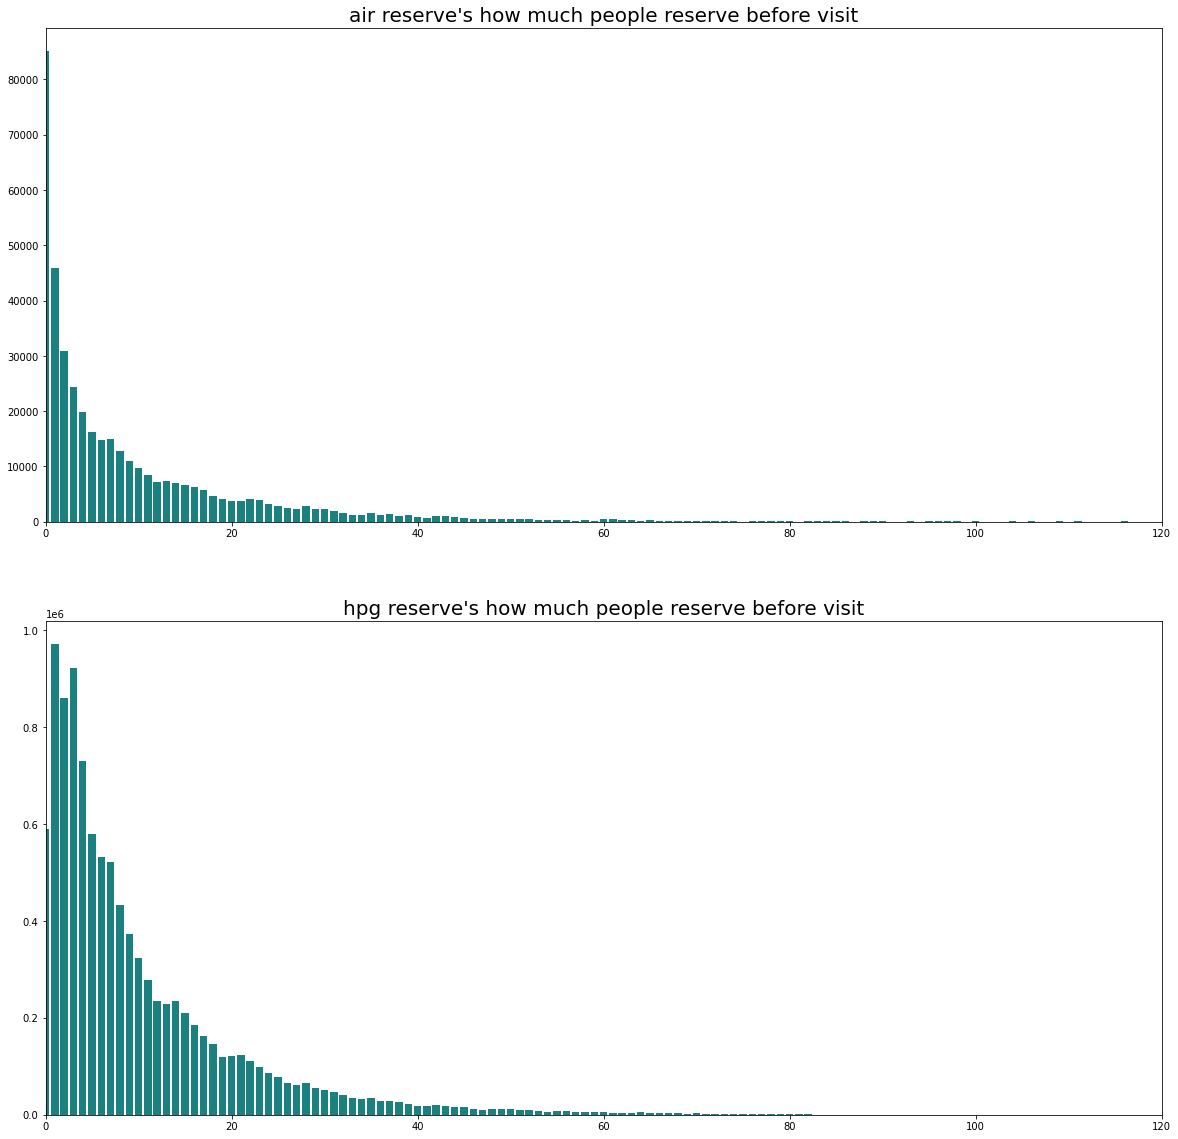

In [57]:
temp = eda['ar'].groupby(['diff'],as_index=False)['reserve_visitors'].sum()
# temp.head()
_title = {'ar':'air reserve\'s ','hr':'hpg reserve\'s '}

plt.figure(figsize=(20,20))
for idx, df in enumerate(['ar','hr']):
    plt.subplot(2,1,idx+1)
    temp = eda[df].groupby(['diff'],as_index=False)['reserve_visitors'].sum()
    _title_temp = _title[df]+'how much people reserve before visit'
    plt.title(_title_temp,fontsize=20)
    plt.xlim(0,120)
    plt.bar(temp['diff'],temp['reserve_visitors'],color=(0.1,0.5,0.5))

plt.show()

## as, hs: air_store_info, hpg_store_info
- histogram으로 확인

In [180]:
# genre name 확인
print(eda['asi']['air_genre_name'].unique())

['Italian/French' 'Dining bar' 'Yakiniku/Korean food' 'Cafe/Sweets'
 'Izakaya' 'Okonomiyaki/Monja/Teppanyaki' 'Bar/Cocktail' 'Japanese food'
 'Creative cuisine' 'Other' 'Western food' 'International cuisine' 'Asian'
 'Karaoke/Party']


<class 'pandas.core.frame.DataFrame'>


<BarContainer object of 14 artists>

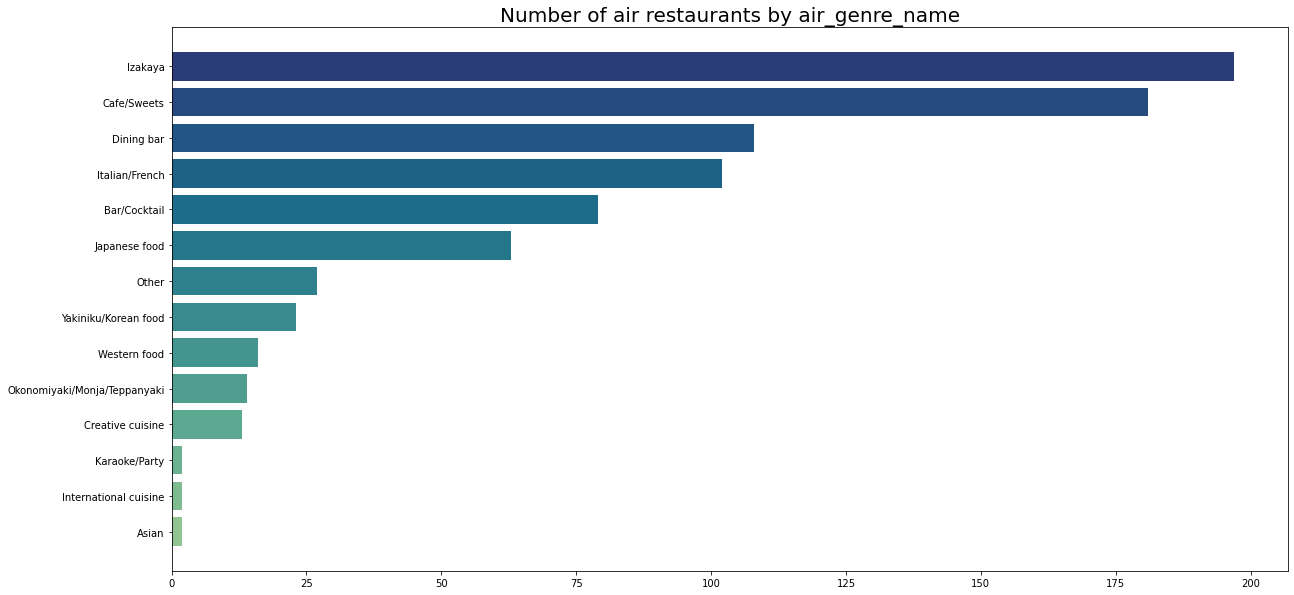

In [58]:
_hist = eda['asi'].groupby(['air_genre_name'], as_index=False)['air_store_id'].count().sort_values('air_store_id', ascending=True)
print(type(_hist))
# _hist = _hist.sort_values('air_store_id', ascending=False)#by=str)
# display(_hist['air_store_id'])
# display(_hist)
plt.figure(figsize=(20,10))
plt.title('Number of air restaurants by air_genre_name', fontsize=20)
colors = sns.color_palette("crest", len(_hist['air_store_id']))
# plt.bar(_hist.index,_hist['air_store_id'])
plt.barh(_hist['air_genre_name'],_hist['air_store_id'],color=colors)

<BarContainer object of 25 artists>

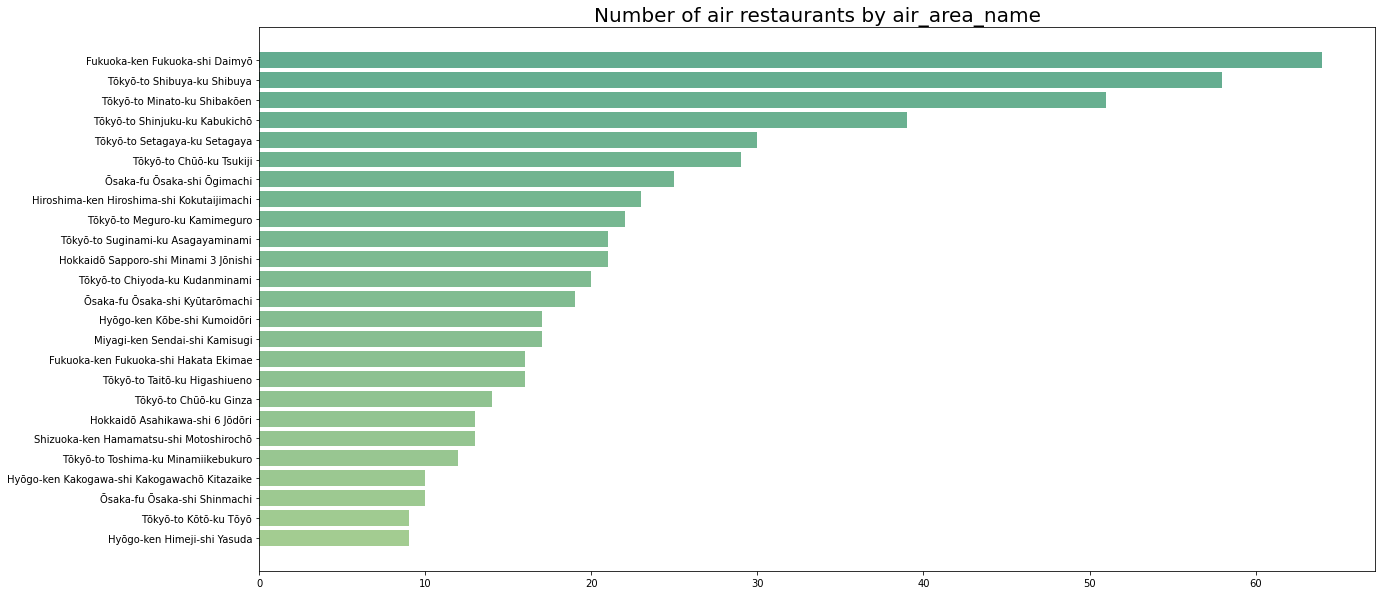

In [59]:
_hist = eda['asi'].groupby(['air_area_name'], as_index=False)['air_store_id'].count().sort_values('air_store_id', ascending=True)
_chk = 25

plt.figure(figsize=(20,10))
plt.title('Number of air restaurants by air_area_name',fontsize=20)
colors = sns.color_palette("crest", len(_hist['air_store_id']))
plt.barh(_hist['air_area_name'][-_chk:],_hist['air_store_id'][-_chk:],color=colors) # 제일 store 많은 지역 top 15


## HPG Store

<class 'pandas.core.frame.DataFrame'>


<BarContainer object of 34 artists>

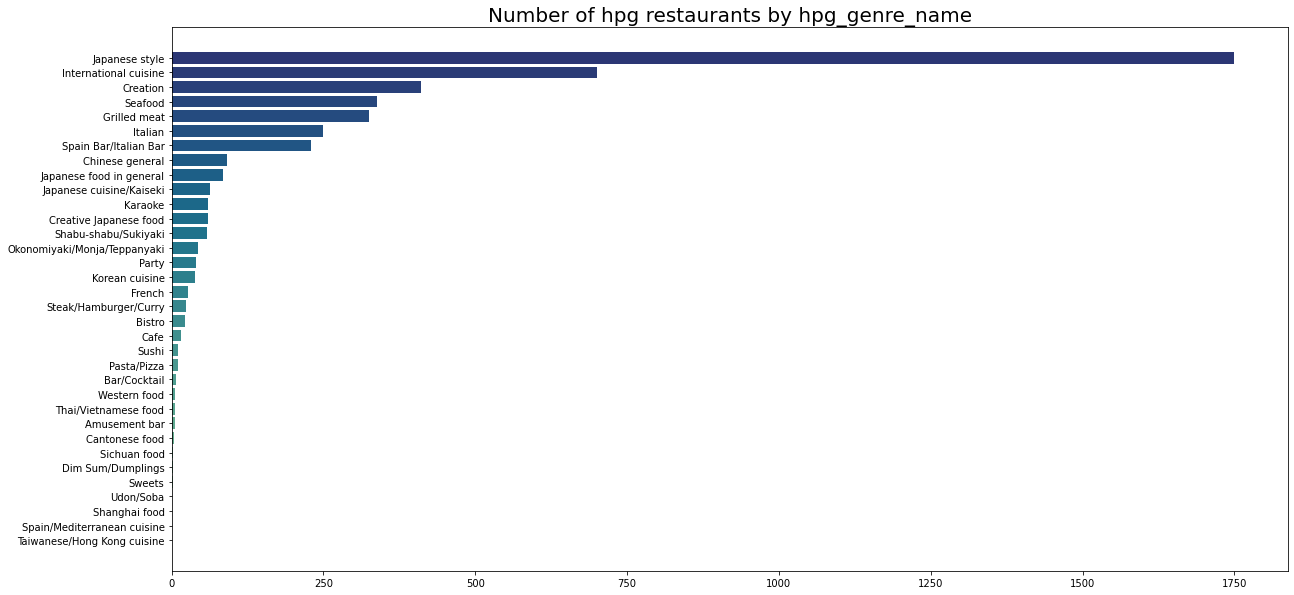

In [60]:
_hist = eda['hsi'].groupby(['hpg_genre_name'], as_index=False)['hpg_store_id'].count().sort_values('hpg_store_id', ascending=True)
print(type(_hist))
plt.figure(figsize=(20,10))
plt.title('Number of hpg restaurants by hpg_genre_name', fontsize=20)
colors = sns.color_palette("crest", len(_hist['hpg_store_id']))
plt.barh(_hist['hpg_genre_name'],_hist['hpg_store_id'],color=colors)

<class 'pandas.core.frame.DataFrame'>


<BarContainer object of 20 artists>

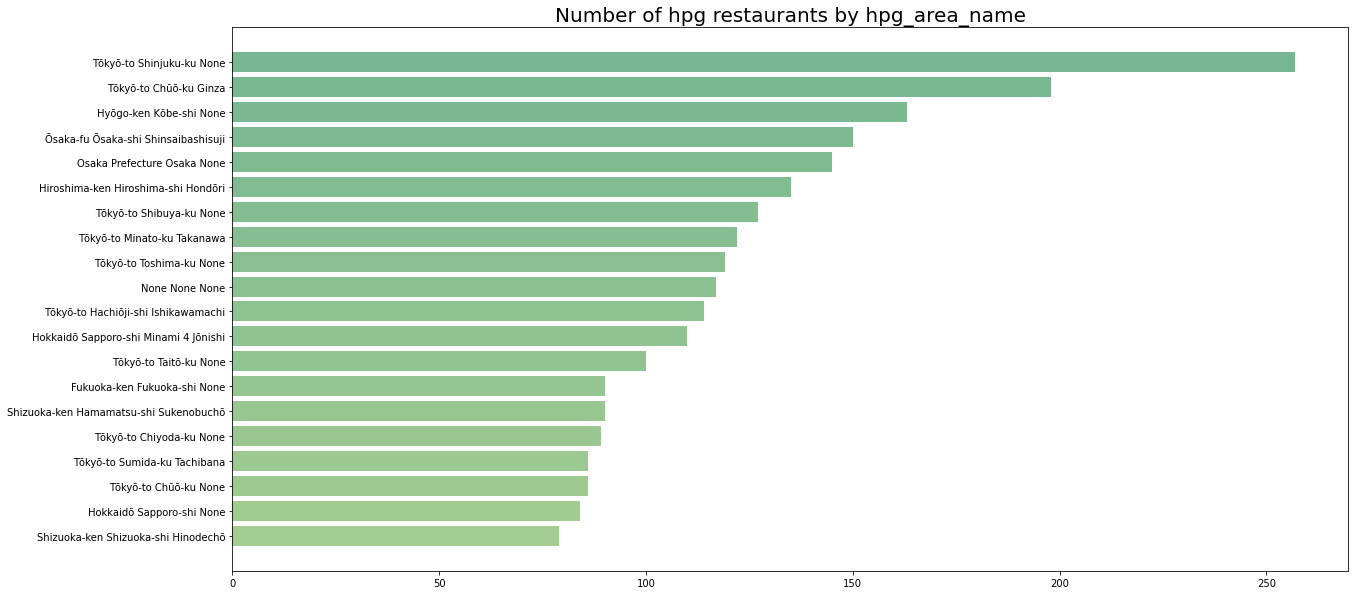

In [62]:
_hist = eda['hsi'].groupby(['hpg_area_name'], as_index=False)['hpg_store_id'].count().sort_values('hpg_store_id', ascending=True)
print(type(_hist))
plt.figure(figsize=(20,10))
plt.title('Number of hpg restaurants by hpg_area_name',fontsize=20)
# plt.bar(_hist.index,_hist['air_store_id'])
colors = sns.color_palette("crest", len(_hist['hpg_store_id']))
plt.barh(_hist['hpg_area_name'][-20:],_hist['hpg_store_id'][-20:],color=colors) # 제일 store 많은 지역 top 15


## hol: date_info

In [185]:
eda['data_info'].head()

,visit_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


,holiday_flg,visit_date,day_of_week
0,0,482,482
1,1,35,35


<BarContainer object of 2 artists>

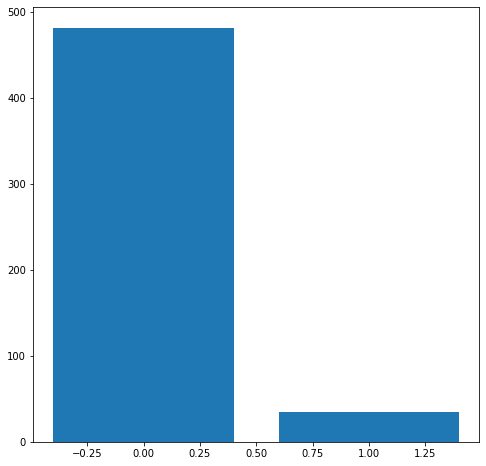

In [186]:
temp=eda['data_info'].groupby(['holiday_flg'], as_index=False).count()
display(temp.head())
plt.figure(figsize=(8,8))
plt.bar(temp['holiday_flg'],temp['day_of_week'])

# Correlation 확인
- [sns 이용하여 correlation 후 Heatmap 으로 확인](https://m.blog.naver.com/kiddwannabe/221763497317)




- 수치형 데이터에 대해서 correlation 을 확인하는 듯
- 통계적 수치에 대한 column 들 추가할 필요
- 의문점
    - 상관 관계에 대해서 알면 그 다음을 예측함에 있어서 도움이 된단 말인가??
    - 양상이 비슷한 것을 찾아야함
    - 분포의 비슷함은 regression에 도움을 줄 것이란 생각은 안듦...
    - 양상의 비슷함은 model fitting 하는 방법으로 해야함
    - lineplot으로 확인했던 그런 방법...
    dow, holiday_flg, min/max/mean/median visitors

['dow', 'year', 'month', 'day_of_week', 'holiday_flg', 'min_visitors', 'mean_visitors', 'median_visitors', 'max_visitors', 'count_observations', 'air_genre_name', 'air_area_name', 'latitude', 'longitude', 'air_genre_name0', 'air_area_name0', 'air_genre_name1', 'air_area_name1', 'air_genre_name2', 'air_area_name2', 'air_genre_name3', 'air_area_name3', 'air_genre_name4', 'air_area_name4', 'air_genre_name5', 'air_area_name5', 'air_genre_name6', 'air_area_name6', 'air_genre_name7', 'air_area_name7', 'air_genre_name8', 'air_area_name8', 'air_genre_name9', 'air_area_name9', 'rs_sum_x', 'rv_sum_x', 'rs_mean_x', 'rv_mean_x', 'rs_sum_y', 'rv_sum_y', 'rs_mean_y', 'rv_mean_y', 'total_reserv_sum', 'total_reserv_mean', 'total_reserv_dt_diff_mean', 'date_int', 'var_max_lat', 'var_max_long', 'lon_plus_lat', 'air_store_id2']

In [187]:
for df in ['ar','hr']:
    eda[df]['visit_datetime'] = pd.to_datetime(eda[df]['visit_datetime'])
    eda[df]['dow'] = eda[df]['visit_datetime'].dt.dayofweek
    eda[df]['year'] = eda[df]['visit_datetime'].dt.year
    eda[df]['month'] = eda[df]['visit_datetime'].dt.month
    eda[df]['visit_datetime'] = eda[df]['visit_datetime'].dt.date

    display(eda[df].head())

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,v_hr,r_hr,diff,dow,year,month
0,air_877f79706adbfb06,2016-01-01,2016-01-01,1,19,16,0,4,2016,1
1,air_db4b38ebe7a7ceff,2016-01-01,2016-01-01,3,19,19,0,4,2016,1
2,air_db4b38ebe7a7ceff,2016-01-01,2016-01-01,6,19,19,0,4,2016,1
3,air_877f79706adbfb06,2016-01-01,2016-01-01,2,20,16,0,4,2016,1
4,air_db80363d35f10926,2016-01-01,2016-01-01,5,20,01,0,4,2016,1


,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors,v_hr,r_hr,diff,dow,year,month
0,hpg_c63f6f42e088e50f,2016-01-01,2016-01-01,1,11,09,0,4,2016,1
1,hpg_dac72789163a3f47,2016-01-01,2016-01-01,3,13,06,0,4,2016,1
2,hpg_c8e24dcf51ca1eb5,2016-01-01,2016-01-01,2,16,14,0,4,2016,1
3,hpg_24bb207e5fd49d4a,2016-01-01,2016-01-01,5,17,11,0,4,2016,1
4,hpg_25291c542ebb3bc2,2016-01-01,2016-01-01,13,17,03,0,4,2016,1


In [188]:
ar = {}
hr = {}

ar['sum'] =  eda['ar'].groupby(['air_store_id','visit_datetime'], as_index=False)[['diff', 'reserve_visitors']].sum()
ar['mean'] = eda['ar'].groupby(['air_store_id','visit_datetime'], as_index=False)[['diff', 'reserve_visitors']].mean()
ar['median'] = eda['ar'].groupby(['air_store_id','visit_datetime'], as_index=False)[['diff', 'reserve_visitors']].median()
ar['min'] = eda['ar'].groupby(['air_store_id','visit_datetime'], as_index=False)[['diff', 'reserve_visitors']].min()
ar['max'] = eda['ar'].groupby(['air_store_id','visit_datetime'], as_index=False)[['diff', 'reserve_visitors']].max()

hr['sum'] = eda['hr'].groupby(['hpg_store_id','visit_datetime'], as_index=False)[['diff', 'reserve_visitors']].sum()
hr['mean'] = eda['hr'].groupby(['hpg_store_id','visit_datetime'], as_index=False)[['diff', 'reserve_visitors']].mean()
hr['median'] = eda['hr'].groupby(['hpg_store_id','visit_datetime'], as_index=False)[['diff', 'reserve_visitors']].median()
hr['min'] = eda['hr'].groupby(['hpg_store_id','visit_datetime'], as_index=False)[['diff', 'reserve_visitors']].min()
hr['max'] = eda['hr'].groupby(['hpg_store_id','visit_datetime'], as_index=False)[['diff', 'reserve_visitors']].max()



In [189]:
eda['ar'].head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,v_hr,r_hr,diff,dow,year,month
0,air_877f79706adbfb06,2016-01-01,2016-01-01,1,19,16,0,4,2016,1
1,air_db4b38ebe7a7ceff,2016-01-01,2016-01-01,3,19,19,0,4,2016,1
2,air_db4b38ebe7a7ceff,2016-01-01,2016-01-01,6,19,19,0,4,2016,1
3,air_877f79706adbfb06,2016-01-01,2016-01-01,2,20,16,0,4,2016,1
4,air_db80363d35f10926,2016-01-01,2016-01-01,5,20,01,0,4,2016,1


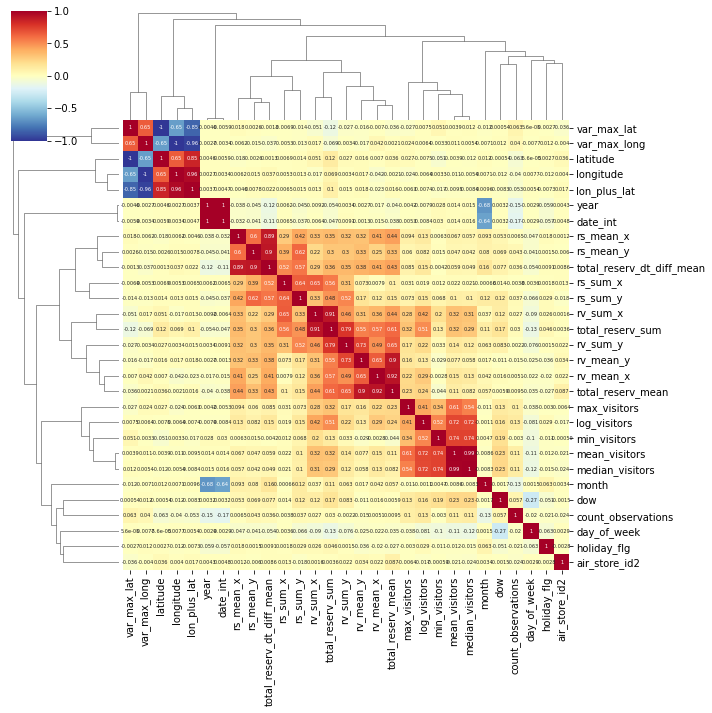

In [190]:
# ch=eda['ar'].corr()
col = [c for c in train if c not in ['id', 'air_store_id', 'visit_date', 'visitors',
                                       'air_genre_name', 'air_area_name',
                                       'air_genre_name0', 'air_area_name0', 'air_genre_name1',
                                       'air_area_name1', 'air_genre_name2', 'air_area_name2',
                                       'air_genre_name3', 'air_area_name3', 'air_genre_name4',
                                       'air_area_name4', 'air_genre_name5', 'air_area_name5',
                                       'air_genre_name6', 'air_area_name6', 'air_genre_name7',
                                       'air_area_name7', 'air_genre_name8', 'air_area_name8',
                                       'air_genre_name9', 'air_area_name9']]
ch = (pd.concat([train[col], pd.Series(np.log1p(train['visitors'].values), name = 'log_visitors')], axis = 1)).corr()

sns.clustermap(ch, 
               annot = True,      # 실제 값 화면에 나타내기
               cmap = 'RdYlBu_r',  # Red, Yellow, Blue 색상으로 표시
               vmin = -1, vmax = 1, #컬러차트 -1 ~ 1 범위로 표시
               annot_kws={'size':5}
              )

In [191]:
train[col]

,dow,year,month,day_of_week,holiday_flg,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations,...,rs_mean_y,rv_mean_y,total_reserv_sum,total_reserv_mean,total_reserv_dt_diff_mean,date_int,var_max_lat,var_max_long,lon_plus_lat,air_store_id2
0,2,2016,1,6,0,7.0,23.843750,25.0,57.0,64.0,...,NaN,NaN,NaN,NaN,NaN,20160113,8.362564,4.521799,175.409667,603
1,3,2016,1,4,0,2.0,20.292308,21.0,54.0,65.0,...,NaN,NaN,NaN,NaN,NaN,20160114,8.362564,4.521799,175.409667,603
2,4,2016,1,0,0,4.0,34.738462,35.0,61.0,65.0,...,NaN,NaN,NaN,NaN,NaN,20160115,8.362564,4.521799,175.409667,603
3,5,2016,1,2,0,6.0,27.651515,27.0,53.0,66.0,...,NaN,NaN,NaN,NaN,NaN,20160116,8.362564,4.521799,175.409667,603
4,0,2016,1,1,0,2.0,13.754386,12.0,34.0,57.0,...,NaN,NaN,NaN,NaN,NaN,20160118,8.362564,4.521799,175.409667,603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252103,1,2017,4,5,0,2.0,5.615385,6.0,11.0,39.0,...,NaN,NaN,NaN,NaN,NaN,20170418,8.367414,4.562362,175.364254,98
252104,2,2017,4,6,0,2.0,6.575000,6.0,25.0,40.0,...,NaN,NaN,NaN,NaN,NaN,20170419,8.367414,4.562362,175.364254,98
252105,3,2017,4,4,0,2.0,5.394737,6.0,8.0,38.0,...,NaN,NaN,NaN,NaN,NaN,20170420,8.367414,4.562362,175.364254,98
252106,4,2017,4,0,0,2.0,5.738095,6.0,9.0,42.0,...,NaN,NaN,NaN,NaN,NaN,20170421,8.367414,4.562362,175.364254,98


# 타겟 변수에 대한 간단한 시각화
- 오른쪽 꼬리가 긴 분포(right skewed)이므로 log변환해준다
  - 그럼 y가 어느정도 정규분포 가정을 만족한다
  - ~~[Trouble] countplot은 범주형 변수를 세는거야~~

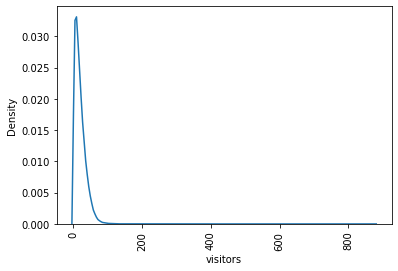

In [193]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.kdeplot(train['visitors'])
plt.xticks(rotation=90)
plt.show()

<AxesSubplot:xlabel='visitors', ylabel='Density'>

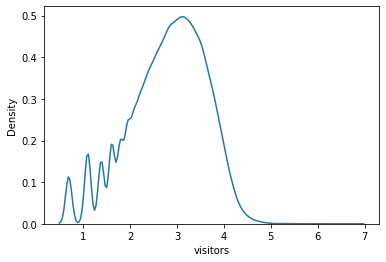

In [194]:
sns.kdeplot( np.log1p(train['visitors']) )

# Model Prediction & Evaluation

- 평가지표인 RMSLE를 계산하는 함수

In [195]:
def RMSLE(y, pred):
    return metrics.mean_squared_error(y, pred)**0.5

- 범주형 변수와 target변수를 제외하고 모두 포함시킨다
  - [Trouble] -1로 놓는게 어떤 의미가 있지 ? 데이터에서 의미없는 값으로 추정됨!

In [196]:
col = [c for c in train if c not in ['id', 'air_store_id', 'visit_date','visitors']]
print(col)
train = train.fillna(-1) 
test = test.fillna(-1)

['dow', 'year', 'month', 'day_of_week', 'holiday_flg', 'min_visitors', 'mean_visitors', 'median_visitors', 'max_visitors', 'count_observations', 'air_genre_name', 'air_area_name', 'latitude', 'longitude', 'air_genre_name0', 'air_area_name0', 'air_genre_name1', 'air_area_name1', 'air_genre_name2', 'air_area_name2', 'air_genre_name3', 'air_area_name3', 'air_genre_name4', 'air_area_name4', 'air_genre_name5', 'air_area_name5', 'air_genre_name6', 'air_area_name6', 'air_genre_name7', 'air_area_name7', 'air_genre_name8', 'air_area_name8', 'air_genre_name9', 'air_area_name9', 'rs_sum_x', 'rv_sum_x', 'rs_mean_x', 'rv_mean_x', 'rs_sum_y', 'rv_sum_y', 'rs_mean_y', 'rv_mean_y', 'total_reserv_sum', 'total_reserv_mean', 'total_reserv_dt_diff_mean', 'date_int', 'var_max_lat', 'var_max_long', 'lon_plus_lat', 'air_store_id2']


- 앙상블 기법을 적용하기 위해 4가지 모델을 이용한다
  - GradientBoostingRegressor
  - KNeighborsRegressor
  - XGBRegressor
  - LGBMRegressor

- 참고자료: [xgboost GPU 사용하기](https://www.kaggle.com/vinhnguyen/accelerating-xgboost-with-gpu)

In [203]:
#200, 280, 280
for c in [100, 200, 300, 400, 500]:
    model1 = ensemble.GradientBoostingRegressor(learning_rate=0.2, random_state=3, n_estimators=c, subsample=0.8, 
                          max_depth =10)
    model2 = neighbors.KNeighborsRegressor(n_jobs=-1, n_neighbors=4)
    model3 = XGBRegressor(learning_rate=0.2, random_state=3, n_estimators=c, subsample=0.8, 
                          colsample_bytree=0.8, max_depth =12, tree_method = 'gpu_hist')
    model4 = lgb.LGBMRegressor(learning_rate=0.2, random_state=3, n_estimators=c, subsample=0.8, 
                          colsample_bytree=0.8, max_depth =12)
    
    model1.fit(train[col], np.log1p(train['visitors'].values))
    model2.fit(train[col], np.log1p(train['visitors'].values))
    model3.fit(train[col], np.log1p(train['visitors'].values))
    model4.fit(train[col], np.log1p(train['visitors'].values))

    preds1 = model1.predict(train[col])
    preds2 = model2.predict(train[col])
    preds3 = model3.predict(train[col])
    preds4 = model4.predict(train[col])
    
    print('-----{ learning_rate: 0.2, n_estimators:',f'{c}','}-----')
    print('RMSE GradientBoostingRegressor: ', RMSLE(np.log1p(train['visitors'].values), preds1))
    print('RMSE KNeighborsRegressor: ', RMSLE(np.log1p(train['visitors'].values), preds2))
    print('RMSE XGBRegressor: ', RMSLE(np.log1p(train['visitors'].values), preds3))
    print('RMSE LGBMRegressor: ', RMSLE(np.log1p(train['visitors'].values), preds4))

-----{ learning_rate: 0.2, n_estimators: 100 }-----
RMSE GradientBoostingRegressor:  0.40123113222263257
RMSE KNeighborsRegressor:  0.41945171611410526
RMSE XGBRegressor:  0.35152900138098675
RMSE LGBMRegressor:  0.4840822799942041
-----{ learning_rate: 0.2, n_estimators: 200 }-----
RMSE GradientBoostingRegressor:  0.3480211759737828
RMSE KNeighborsRegressor:  0.41945171611410526
RMSE XGBRegressor:  0.27241167727545645
RMSE LGBMRegressor:  0.47270764114362146
-----{ learning_rate: 0.2, n_estimators: 300 }-----
RMSE GradientBoostingRegressor:  0.30804382315588813
RMSE KNeighborsRegressor:  0.41945171611410526
RMSE XGBRegressor:  0.21466564475319447
RMSE LGBMRegressor:  0.4651567546823683


KeyboardInterrupt: 

In [204]:
model1 = ensemble.GradientBoostingRegressor(learning_rate=0.2, random_state=3, n_estimators=200, subsample=0.8, 
                      max_depth =10)
model2 = neighbors.KNeighborsRegressor(n_jobs=-1, n_neighbors=4)
model3 = XGBRegressor(learning_rate=0.2, random_state=3, n_estimators=280, subsample=0.8, 
                      colsample_bytree=0.8, max_depth =12, tree_method = 'gpu_hist')
model4 = lgb.LGBMRegressor(learning_rate=0.2, random_state=3, n_estimators=280, subsample=0.8, 
                      colsample_bytree=0.8, max_depth =12)
model1.fit(train[col], np.log1p(train['visitors'].values))
model2.fit(train[col], np.log1p(train['visitors'].values))
model3.fit(train[col], np.log1p(train['visitors'].values))
model4.fit(train[col], np.log1p(train['visitors'].values))

preds1 = model1.predict(train[col])
preds2 = model2.predict(train[col])
preds3 = model3.predict(train[col])
preds4 = model4.predict(train[col])

print('RMSE GradientBoostingRegressor: ', RMSLE(np.log1p(train['visitors'].values), preds1))
print('RMSE KNeighborsRegressor: ', RMSLE(np.log1p(train['visitors'].values), preds2))
print('RMSE XGBRegressor: ', RMSLE(np.log1p(train['visitors'].values), preds3))
print('RMSE LGBMRegressor: ', RMSLE(np.log1p(train['visitors'].values), preds4))

RMSE GradientBoostingRegressor:  0.3480211759737828
RMSE KNeighborsRegressor:  0.41945171611410526
RMSE XGBRegressor:  0.22353260966610924
RMSE LGBMRegressor:  0.4666561090846041


In [205]:
model_list = [model1, model3, model4]
model_name_list = ['GradientBoostingRegressor', 'XGBRegressor', 'LGBMRegressor']
model_df = {}
for idx, model in enumerate(model_list, 1):
    model_df['model'+str(idx)] = pd.DataFrame({"var": col, "imp": model.feature_importances_})
    model_df['model'+str(idx)] = model_df['model'+str(idx)].sort_values(['imp'], ascending=False)

- 참고자료: [그래프 간 간격조절](https://steadiness-193.tistory.com/174)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


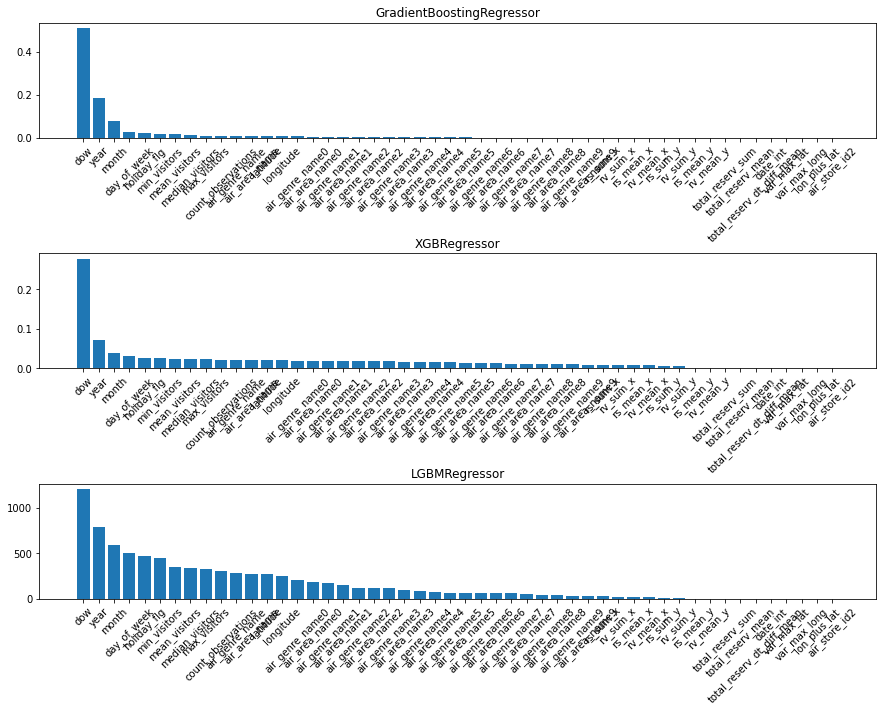

In [206]:
fig = plt.figure(figsize = (15, 10))
ax = fig.subplots(nrows=3, ncols=1)
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=1)
plt.xticks(rotation=90)

i = 0
for name, df in model_df.items():
    ax.flatten()[i].bar(df['var'], df['imp'])
    ax.flatten()[i].set_title(model_name_list[i])
    ax.flatten()[i].set_xticklabels(col, rotation = 45)
    i += 1


- KEEP IT SIMPLE STUPID,`Bagging` 기법을 사용하기 위해 모델별 평균낸 값으로 예측치를 사용한다!

In [207]:
preds1 = model1.predict(test[col])
preds2 = model2.predict(test[col])
preds3 = model3.predict(test[col])
preds4 = model4.predict(test[col])

test['visitors'] = 0.25*preds1 + 0.25*preds2 + 0.25*preds3 + 0.25*preds4 
test['visitors'] = np.expm1(test['visitors']).clip(lower=0.)
sub1 = test[['id','visitors']].copy()
sub1.to_csv('submission.csv', index=False)
del train; del data;

# [회고]
  - WeatherData를 구했으나 시간적 제약으로 인해 사용하지 못함
  - 참고자료
  
[Surprise Me](https://www.kaggle.com/tunguz/surprise-me-2): 관계형 데이터의 정리 및 모델링 파라미터 설정을 위해 참고함

[Max halford 분석자료](https://github.com/MaxHalford/kaggle-recruit-restaurant): feature_importances_ 표현하는데 참고함

[1st Place LGB Model](https://www.kaggle.com/pureheart/1st-place-lgb-model-public-0-470-private-0-502/comments)

- 코드 : 파이썬으로 구현
- 설명이 안나와있음.. (400줄이 꽤 촘촘하게 있는 코드라 일단 빠른시간에 파악 불가)

[A Very Extensive Recruit Exploratory Analysis](https://www.kaggle.com/captcalculator/a-very-extensive-recruit-exploratory-analysis)

- data 를 파일별 shape 확인해놔줌(참고 좋음)
- 예약한 날짜와 예약 날짜 간의 차이에 주목하고 있음 +
- EDA 와 visualize 가 잘되어있는 자료고 그것에 초점

[Feeling Hungry? A Beginner's guide to ARIMA models](https://www.kaggle.com/timolee/feeling-hungry-a-beginner-s-guide-to-arima-models)

- ARIMA model ([Autoregressive Integrated Moving Average Model](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/)) : time series forcasting 에 좋은 model
- 결과 그래프를 보면 양상이 비슷하게 나옴(괜찮은 듯..)
- 참조 링크의 사이트는 장르별로 방문자의 수를 학습시켜서 진행한 듯

[Surprise me! H2O autoML version](https://www.kaggle.com/pranav84/surprise-me-h2o-automl-version)

- 이것도 코드만 올려놈...
- 대충 봤을 때 xgboost, h2o 를 사용한 듯

[weighted mean comparisons, LB 0.497, 1ST](https://www.kaggle.com/zeemeen/weighted-mean-comparisons-lb-0-497-1st)

- 가중합 인듯 한데 코드가 꽤 간결한 느낌(양이 짧음)

[1st Place LGB Model](https://www.kaggle.com/pureheart/1st-place-lgb-model-public-0-470-private-0-502/comments)

- 코드 : 파이썬으로 구현
- 설명이 안나와있음.. (400줄이 꽤 촘촘하게 있는 코드라 일단 빠른시간에 파악 불가)

[A Very Extensive Recruit Exploratory Analysis](https://www.kaggle.com/captcalculator/a-very-extensive-recruit-exploratory-analysis)

- data 를 파일별 shape 확인해놔줌(참고 좋음)
- 예약한 날짜와 예약 날짜 간의 차이에 주목하고 있음 +
- EDA 와 visualize 가 잘되어있는 자료고 그것에 초점

[Feeling Hungry? A Beginner's guide to ARIMA models](https://www.kaggle.com/timolee/feeling-hungry-a-beginner-s-guide-to-arima-models)

- ARIMA model ([Autoregressive Integrated Moving Average Model](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/)) : time series forcasting 에 좋은 model
- 결과 그래프를 보면 양상이 비슷하게 나옴(괜찮은 듯..)
- 참조 링크의 사이트는 장르별로 방문자의 수를 학습시켜서 진행한 듯

[Surprise me! H2O autoML version](https://www.kaggle.com/pranav84/surprise-me-h2o-automl-version)

- 이것도 코드만 올려놈...
- 대충 봤을 때 xgboost, h2o 를 사용한 듯

[weighted mean comparisons, LB 0.497, 1ST](https://www.kaggle.com/zeemeen/weighted-mean-comparisons-lb-0-497-1st)

- 가중합 인듯 한데 코드가 꽤 간결한 느낌(양이 짧음)

- [LSTM](https://www.kaggle.com/yekenot/explore-ts-with-lstm)
    - [suprise me H2O autoML](https://www.kaggle.com/pranav84/surprise-me-h2o-automl-version)